In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from numpy import load
import math
%matplotlib inline

For each day, we count the searches mapped to each of these symptoms and organize the data by geographic region. The resulting dataset is a daily or weekly time series for each region showing the relative frequency of searches for each symptom.

# Preparing Datasets

### Symptom Rate Queries (2020 & 2021)

In [3]:
F = pd.read_csv('data/current/2020_country_daily_2020_US_daily_symptoms_dataset.csv')[['date', 'sub_region_1_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']]
F.columns = ['date', 'open_covid_region_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
F = F[F['open_covid_region_code'].notna()]
F = F.sort_values(by=['open_covid_region_code'])
F = F.fillna(0)

In [4]:
F_2021 = pd.read_csv('data/current/2021_country_daily_2021_US_daily_symptoms_dataset.csv')[['date', 'sub_region_1_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']]
F_2021.columns = ['date', 'open_covid_region_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
F_2021 = F_2021[F_2021['open_covid_region_code'].notna()]
F_2021 = F_2021.sort_values(by=['open_covid_region_code'])
F_2021 = F_2021.fillna(0)

### Training Covid-19 Cases (2020-2021)

In [5]:
actual_cases = pd.read_csv('data/all-states-history.csv')[['date','state','positiveIncrease']]

In [6]:
# EXLCUDING: AS(America Samoa), GU(Guam), MP(Northern Mariana Islands), PR(Puerto Rico), VI(Virgin Islands)
OVERLAPPING_STATES = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 
                      'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 
                      'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 
                      'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

actual_cases = actual_cases[actual_cases['state'].isin(OVERLAPPING_STATES)]
unique_dates = actual_cases['date'].unique()

lacking = []
for date in unique_dates:
    if len(actual_cases[actual_cases.date == date]) == 51:
        continue
    else: 
        lacking.append(date)
        
print("last date without full 51 states: ", max(lacking))
actual_cases = actual_cases[actual_cases.date > '2020-03-06'].sort_values(by=['date', 'state'], ascending=True)

last date without full 51 states:  2020-03-06


#### Covid-19 Case Data for Testing

In [7]:
actual_cases_testing = pd.read_csv('data/all-states-history_till_MARCH.csv')[['date','state','positiveIncrease']]
actual_cases_testing = actual_cases_testing[actual_cases_testing['state'].isin(OVERLAPPING_STATES)]
unique_dates = actual_cases_testing['date'].unique()
lacking = []
for date in unique_dates:
    if len(actual_cases_testing[actual_cases_testing.date == date]) == 51:
        continue
    else: 
        lacking.append(date)
print("last date without full 51 states: ", max(lacking))
actual_cases_testing = actual_cases_testing[actual_cases_testing.date > '2020-03-06'].sort_values(by=['date', 'state'], ascending=True)
print("max day is", max(actual_cases_testing.date))

last date without full 51 states:  2020-03-06
max day is 2021-03-07


### Covid-19 Testing Data

In [57]:
T = pd.read_csv("data/COVID-19/data_tables/testing_data/time_series_covid19_US.csv")[['date', 'state', 'tests_viral_total', 'people_viral_total']]
def convert_time(row):
    row.date = datetime.datetime.strptime(row.date, '%m/%d/%y').strftime('%Y-%m-%d')
    return row
def get_daily_tests(state, start, end):
    window_T = T[(T.date >= start) & (T.date <= end)]
    return window_T.loc[window_T.state == state, 'tests_viral_total'].diff()

In [58]:
T = T.apply(lambda row: convert_time(row), axis=1).sort_values(by=['date','state'])

Checking new data

In [8]:
NUM_STATES = F.open_covid_region_code.nunique()
assert NUM_STATES == 51, "NUM_STATES ERROR"
STATES = F.open_covid_region_code.unique()
SYMP_LIST = ['symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 
             'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 
             'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 
             'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
NUM_SYMP = len(SYMP_LIST)
assert NUM_SYMP == 17, "NUM SYMP ERROR"

In [11]:
BORDER_DICT = {
    'US-AK': [],
    'US-AL': ['US-MI', 'US-TN', 'US-GA', 'US-FL'],
    'US-AR': ['US-OK', 'US-TX', 'US-MO', 'US-TN', 'US-MS', 'US-LA'],
    'US-AZ': ['US-NM', 'US-UT', 'US-NV', 'US-CA'],
    'US-CA': ['US-OR', 'US-NV', 'US-AZ'],
    'US-CO': ['US-WY', 'US-NE', 'US-KS', 'US-OK', 'US-NM', 'US-UT'],
    'US-CT': ['US-RI', 'US-MA', 'US-NY'],
    'US-DC': ['US-MD', 'US-VA'],
    'US-DE': ['US-PA', 'US-NJ', 'US-MD'],
    'US-FL': ['US-AL', 'US-GA'],
    'US-GA': ['US-FL', 'US-AL', 'US-TN', 'US-NC', 'US-SC'],
    'US-HI': [],
    'US-IA': ['US-MN', 'US-WI', 'US-IL', 'US-MO', 'US-NE', 'US-SD'],
    'US-ID': ['US-OR', 'US-NV', 'US-UT', 'US-WY', 'US-MT', 'US-WA'],
    'US-IL': ['US-IA', 'US-MO', 'US-KY', 'US-IN', 'US-WI'],
    'US-IN': ['US-MI', 'US-OH', 'US-KY', 'US-LI'],
    'US-KS': ['US-CO', 'US-NE', 'US-MO', 'US-OK'],
    'US-KY': ['US-IL', 'US-IN', 'US-OH', 'US-WV', 'US-VA', 'US-TN', 'US-MO'],
    'US-LA': ['US-TX', 'US-AR', 'US-MS'],
    'US-MA': ['US-NH', 'US-VT', 'US-NY', 'US-RI', 'US-CT'],
    'US-MD': ['US-DE', 'US-VA', 'US-WV', 'US-PA'],
    'US-ME': ['US-NH'],
    'US-MI': ['US-WI', 'US-IN', 'US-OH'],
    'US-MN': ['US-ND', 'US-SD', 'US-IA', 'US-WI'],
    'US-MO': ['US-IA', 'US-IL', 'US-KY', 'US-TN', 'US-AR', 'US-OK', 'US-KS', 'US-NE'], 
    'US-MS': ['US-AL', 'US-TN', 'US-AR', 'US-LA'],
    'US-MT': ['US-ID', 'US-WY', 'US-SD', 'US-ND'],
    'US-NC': ['US-VA', 'US-TN', 'US-GA', 'US-SC'],
    'US-ND': ['US-MT', 'US-SD', 'US-MN'],
    'US-NE': ['US-SD', 'US-IA', 'US-MO', 'US-KS', 'US-CO', 'US-WY'],
    'US-NH': ['US-ME', 'US-VT', 'US-MA'],
    'US-NJ': ['US-PA', 'US-DE', 'US-NY'],
    'US-NM': ['US-AZ', 'US-CO', 'US-OK', 'US-TX'],
    'US-NV': ['US-CA', 'US-OR', 'US-ID', 'US-UT', 'US-AZ'],
    'US-NY': ['US-VT', 'US-MA', 'US-CT', 'US-NJ', 'US-PA'],
    'US-OH': ['US-MI', 'US-IN', 'US-KY', 'US-WV', 'US-PA'],
    'US-OK': ['US-TX', 'US-AR', 'US-MO', 'US-KS', 'US-CO', 'US-NM'],
    'US-OR': ['US-WA', 'US-ID', 'US-NV', 'US-CA'],
    'US-PA': ['US-NJ', 'US-NY', 'US-DE', 'US-MD', 'US-WV', 'US-OH'], 
    'US-RI': ['US-MA', 'US-CT'],
    'US-SC': ['US-NC', 'US-GA'],
    'US-SD': ['US-ND', 'US-MN', 'US-IA', 'US-NE', 'US-WY', 'US-MT'], 
    'US-TN': ['US-KY', 'US-VA', 'US-NC', 'US-GA', 'US-AL', 'US-MS', 'US-AR', 'US-MO'],
    'US-TX': ['US-NM', 'US-OK', 'US-AR', 'US-LA'],
    'US-UT': ['US-NV', 'US-AZ', 'US-CO', 'US-WY', 'US-ID'],
    'US-VA': ['US-WV', 'US-MD', 'US-KY', 'US-TN', 'US-NC'], 
    'US-VT': ['US-NH', 'US-MA', 'US-NY'],
    'US-WA': ['US-OR', 'US-ID'],
    'US-WI': ['US-MI', 'US-IL', 'US-IA', 'US-MN'],
    'US-WV': ['US-OH', 'US-PA', 'US-MD', 'US-VA'],
    'US-WY': ['US-ID', 'US-MT', 'US-SD', 'US-NE', 'US-CO', 'US-UT']
}

# Obtaining Weights & Intercept

In [12]:
def beta(ctrl_region_symp, Ysdn):
    numerator = NUM_SYMP * np.sum(np.multiply(ctrl_region_symp,Ysdn)) - (np.multiply(np.sum(ctrl_region_symp), np.sum(Ysdn)))
    denominator = NUM_SYMP * np.sum(np.square(ctrl_region_symp)) - np.square(np.sum(ctrl_region_symp))
    return numerator / denominator

def epsilon(ctrl_region_symp, Ysdn, beta):
    numerator = np.sum(Ysdn) - (beta * np.sum(ctrl_region_symp))
    return numerator / NUM_SYMP

def R2(e2_list, target_region_symp, mean_symp_rate):
#     mean_symp_rate = np.mean(target_region_symp)
    numerator = np.sum(e2_list)
    denominator = np.sum(np.square(target_region_symp - mean_symp_rate))
    return 1 - (numerator/denominator)

# Returns an array of control states
def get_ctrl_states(target_region):
    index = np.where(STATES != target_region)
    ctrl_states_pool = STATES[index]
    ctrl_states_pool = np.setdiff1d(ctrl_states_pool, BORDER_DICT[target_region])
    return ctrl_states_pool

In [13]:
# F_data = F filtered down to a single date
# data = F_data without target region row

def obtain_weights(F_data, target_region):
    CTRL_REGIONS = get_ctrl_states(target_region)
    data = F_data[F_data.open_covid_region_code.isin(CTRL_REGIONS)]

    target_region = F_data[F_data.open_covid_region_code == target_region]
    target_region_symp_rates = target_region[SYMP_LIST].to_numpy().flatten()
    mean_target_symp_rates = np.mean(target_region_symp_rates)
    
    best_ctrl_region_list = []
    beta_control = np.zeros(5)
    epsilon_control = np.zeros(5)
    mju_list = np.zeros((5, NUM_SYMP))
    best_e2 = np.zeros(5)
    
    for n in range(5):
        R2_list = np.zeros(len(CTRL_REGIONS))
        
        Ysdn = target_region_symp_rates - mju_list[n-1]
        mean_Ysdn = np.mean(Ysdn)
        beta_list = np.zeros(len(CTRL_REGIONS))
        epsilon_list = np.zeros(len(CTRL_REGIONS))
        
        for idx_r, region in enumerate(CTRL_REGIONS):
            region_row = data[data.open_covid_region_code == region]
            region_symp_rates = region_row[SYMP_LIST].to_numpy().flatten()
            
            beta_region = beta(region_symp_rates, Ysdn)
            epsilon_region = epsilon(region_symp_rates, Ysdn, beta_region)
            beta_list[idx_r] = beta_region
            epsilon_list[idx_r] = epsilon_region
                   
            F_hat_s = np.multiply(beta_region, region_symp_rates) + epsilon_region
            e2_list = np.square(Ysdn - F_hat_s)
            
            R2_region = R2(e2_list, Ysdn, mean_Ysdn)
            R2_list[idx_r] = R2_region
        
        best_ctrl_region_idx = R2_list.argmax()
        best_ctrl_region_list.append(CTRL_REGIONS[best_ctrl_region_idx])
        
        CTRL_REGIONS = np.delete(CTRL_REGIONS, best_ctrl_region_idx)
        
        beta_control[n] = beta_list[best_ctrl_region_idx]
        epsilon_control[n] = epsilon_list[best_ctrl_region_idx]
        
        best_region_row = data[data.open_covid_region_code == best_ctrl_region_list[-1]]
        best_region_row = best_region_row[SYMP_LIST].to_numpy().flatten()
        F_hat_s = np.multiply(beta_control[n], best_region_row) + epsilon_control[n]
        
        mju_list[n] = F_hat_s + mju_list[n-1]
        e2 = np.sum(np.square(Ysdn - F_hat_s))
        best_e2[n] = e2
    return best_ctrl_region_list, beta_control, epsilon_control, best_e2
   

### Predicting Symptom Rates

In [14]:
def pred_single_symp_rate(F_data_symp, best_ctrl_regions, beta_control, epsilon_control):
    # F_data_symp = F filtered down to a single date & single symptom column
    F_hat_s = 0
    for i in range(5):
        ctrl_region_symp_rate = F_data_symp[F_data_symp.open_covid_region_code == best_ctrl_regions[i]].to_numpy().flatten()[1] 
        F_hat_s = F_hat_s + beta_control[i] * ctrl_region_symp_rate
    F_hat_s = F_hat_s + np.sum(epsilon_control)
    return F_hat_s

def pred_all_symp_rates(F, date, best_ctrl_regions, beta_control, epsilon_control):
    # Prediction of all 17 symptoms of target region 
    F_data = F[F.date == date]
    F_hat_s_list = np.zeros(NUM_SYMP)
    for idx_s, symp in enumerate(SYMP_LIST):
        F_data_symp = F_data[['open_covid_region_code', symp]]
        F_hat_s = pred_single_symp_rate(F_data_symp, best_ctrl_regions, beta_control, epsilon_control)
        F_hat_s_list[idx_s] = F_hat_s
    return F_hat_s_list

# delta is [17,1]
def delta_symp(ground_truth_symp_rates, pred_symp_rates):
    delta = np.subtract(ground_truth_symp_rates, pred_symp_rates)
    return delta

In [15]:
def get_date(date):
    date_elems = [int(elem) for elem in date.split('-')]
    return datetime.datetime(date_elems[0], date_elems[1], date_elems[2])

# Extend start date back by one day for obtaining weights 
def prepare_date_range(start_date, end_date):
    start = get_date(start_date) + datetime.timedelta(days=-1)
    end = get_date(end_date)
    date_range = list(pd.date_range(start, end))
    date_range = [date.strftime('%Y-%m-%d') for date in date_range]
    return date_range

In [16]:
# Should return Delta Matrix = [period, region, symptoms]
def symptom_rate_pred_model(F, start_date, end_date):
    # date_range includes one extra day in the beginning 
    date_range = prepare_date_range(start_date, end_date)
    period = len(date_range)
    delta_mat = np.zeros((period, NUM_STATES, NUM_SYMP))
    
    # date_range[0] is first obtain weights date: start_date - 1
    # date_range[1] is first day of predictions, date_range[-1] is last day of predictions
    for idx_d, date in enumerate(date_range[:period-1]):
        pred_date = date_range[idx_d+1]
        # delta array of 51 states and their 17 symptoms on 1 day
        delta_day = np.zeros((NUM_STATES, NUM_SYMP))
        query_date_data = F[F.date == pred_date]
        obtain_weight_date = F[F.date == date]
        for idx_r, region in enumerate(STATES):
            actual_symp_rates = query_date_data[query_date_data.open_covid_region_code == region]
            best_ctrl_region_list, beta_control, epsilon_control, best_e2 = obtain_weights(obtain_weight_date, region)   

            F_hat_s_list = pred_all_symp_rates(F, pred_date, best_ctrl_region_list, beta_control, epsilon_control)
            actual_queries = actual_symp_rates.drop(['date', 'open_covid_region_code'], axis = 1).to_numpy().flatten()
            delta_region = delta_symp(actual_queries, F_hat_s_list)
     
            delta_day[idx_r] = delta_region      
        delta_mat[idx_d] = delta_day
    return delta_mat, period

### Creating new Delta:

In [17]:
# New delta shape (period, region)

NEW_NUM_SYMP = 1
def new_delta_mat(delta_mat, period, idx_symp1, idx_symp2):
    new_delta_mat = np.zeros((period, NUM_STATES))
    for idx_d in range(period):
        # delta day shape (51,)
        delta_day = delta_mat[idx_d]
        delta_symp_1_2 = np.array([ np.multiply(delta_region[idx_symp1], delta_region[idx_symp2]) for delta_region in delta_day])
        new_delta_mat[idx_d] = delta_symp_1_2
    return new_delta_mat

## Symptom Rates Outbreak Detection (L_Hat)

In [19]:
# Average delta of all days for each region
# delta mat shape (period, region)

def average_delta(period, delta_mat):
    ave_mat = np.zeros(NUM_STATES)
    for idx_r, delta_region in enumerate(delta_mat.transpose()):
        ave_region = np.mean(delta_region)
        ave_mat[idx_r] = ave_region
    return ave_mat

def std_dev_delta(period, delta_mat):
    std_mat = np.zeros(NUM_STATES)
    for idx_r, delta_region in enumerate(delta_mat.transpose()):
        std_region = np.std(delta_region)
        std_mat[idx_r] = std_region
    return std_mat

def z_score(delta_mat, ave_mat, std_mat, period):
    z_score = np.zeros((period, NUM_STATES))
    for idx_d, delta_day in enumerate(delta_mat):
        z_day = np.divide(np.subtract(delta_day, ave_mat), std_mat)
        z_score[idx_d] = z_day
    return z_score

def L_score(z_score, TH):
    L_score = z_score > TH
    return L_score.astype(int)

In [20]:
# period is the number of days that there are predictions (not including extra day for obtaining weights)
def pred_outbreak_detection(delta_mat, period, TH):
    ave_mat = average_delta(period, delta_mat)
    std_mat = std_dev_delta(period, delta_mat)
    z = z_score(delta_mat, ave_mat, std_mat, period)
    l_score = L_score(z, TH)
    return l_score

## Covid-19 Case Outbreak Detection (L)

In [21]:
# FOR WHOLE Period
def covid_case_outbreak_detection_all(X, target_region):
    X_target = X[X.state == target_region].drop(['date', 'state'], axis=1).to_numpy().flatten()
    X_target[X_target < 1] = 1  
    period = len(X_target)
    C = np.zeros(period)
    for idx, X_day in enumerate(X_target):
        if idx == 0:
            continue  
        Cd = np.divide( np.subtract(X_day, X_target[idx-1]) , X_target[idx-1])
        C[idx] = Cd 
    temp = np.copy(C)
    std_C = np.std(C)
    temp[temp > (3 * std_C)] = 0
    std_C = np.std(temp)
    L_score = C > (2 * std_C)
    return L_score.astype(int)

## Comparison

__L__ is Actual __L_hat__ is Symp Rate Outbreak

In [22]:
def get_target_region_idx(target_region):
    i, = np.where(STATES == target_region)
    return i.item()

def window_L(L, lag, period_L_hat):
    idx = np.arange(lag, lag + period_L_hat)
    L_window = L[idx]
    return L_window

def comparison_all(target_region, L, L_hat, lag):
    target_reg_idx = get_target_region_idx(target_region)
    L_hat_region = L_hat.transpose()[target_reg_idx]
    period = L_hat.shape[0]
    assert len(L_hat_region) == period, "L_hat_region size issue"
    
    L_window = window_L(L, lag, period)
    Lw = np.zeros(7)
    S = np.zeros((period, 2))
    
    counted = []
    for idx_L, L_hat_day in enumerate(L_hat_region): 
        # w holds date indexes of L_window to be compared w L_hat
        if idx_L < 3: 
            w = np.arange(0, (idx_L+4))
        elif idx_L >= (period-3):
            w = np.arange((idx_L-3), period)
        else: 
            w = np.arange((idx_L-3), (idx_L+4))
        
        Lw = L_window[w]
        s = np.zeros(2)
        if L_hat_day == 1:
            # Is there an outbreak in the Lw window? Get position of outbreak in window
            L_outbreaks = np.argwhere(Lw == 1).flatten()
            # Get outbreak date index
            date_idx_L_outbreaks = w[L_outbreaks]
            # Check to see if the indexes of outbreak dates has been counted. 
            new_outbreaks = np.setdiff1d(date_idx_L_outbreaks, np.array(counted))
            if new_outbreaks.shape[0] > 0:
                idx_outbreak = new_outbreaks[0]
                s[0] = 1
                counted.append(idx_outbreak)
            else:
                s[1] = 1
        S[idx_L] = s
    return S, L_window

In [23]:
def metrics(S, L_window):
    TP_FP = np.sum(S, axis=0)
    FN = np.sum(L_window) - TP_FP[0]
    precision = TP_FP[0] / (TP_FP[0] + TP_FP[1])
    recall = TP_FP[0] / (TP_FP[0] + FN)
    Fscore = 2 * ((precision * recall) / (precision + recall))
    return TP_FP, FN, precision, recall, Fscore

# Training: Loading Delta Data & Creating New Signal: Cough x Fever

In [24]:
data_Jan = load('results/delta/Jan_02_31.npy')
data_Feb = load('results/delta/Feb_01_29.npy')
data_Mar = load('results/delta/Mar_01_31.npy')
data_Apr = load('results/delta/Apr_01_30.npy')
data_May = load('results/delta/May_01_31.npy')
data_Jun = load('results/delta/June_01_30.npy')
data_Jul = load('results/delta/Jul_01_31.npy')
data_Aug = load('results/delta/Aug_01_31.npy')
data_Sept = load('results/delta/Sept_01_30.npy')
data_Oct = load('results/delta/Oct_01_31.npy')
data_Nov = load('results/delta/Nov_01_30.npy')
data_Dec = load('results/delta/Dec_01_31.npy')
data_Jan21 = load('results/delta/Jan21_01_31.npy')
data_Feb21 = load('results/delta/Feb21_01_23.npy')

period_jan = data_Jan.shape[0]
period_feb = data_Feb.shape[0]
period_nov = data_Nov.shape[0]
period_31 = data_Mar.shape[0]
period_30 = data_Apr.shape[0]
period_feb = data_Feb21.shape[0]

# Where only considering Cough x Fever 
# MARCH STARTS ON 7th 
new_delta_Mar = new_delta_mat(data_Mar, period_31, 4, 7)[6:]
new_delta_Apr = new_delta_mat(data_Apr, period_30, 4, 7)
new_delta_May = new_delta_mat(data_May, period_31, 4, 7)
new_delta_Jun = new_delta_mat(data_Jun, period_30, 4, 7)
new_delta_Jul = new_delta_mat(data_Jul, period_31, 4, 7)
new_delta_Aug = new_delta_mat(data_Aug, period_31, 4, 7)
new_delta_Sept = new_delta_mat(data_Sept, period_30, 4, 7)
new_delta_Oct = new_delta_mat(data_Oct, period_31, 4, 7)
new_delta_Nov = new_delta_mat(data_Nov, period_30, 4, 7)
new_delta_Dec = new_delta_mat(data_Dec, period_31, 4, 7)
new_delta_Jan21 = new_delta_mat(data_Jan21, period_31, 4, 7)
new_delta_Feb21 = new_delta_mat(data_Feb21, period_feb, 4, 7)
print("New delta created")

New delta created


In [25]:
# Joining of new delta: 7th Mar - Jan 2021
new_delta = np.concatenate((new_delta_Mar, new_delta_Apr), axis=0)
new_delta = np.concatenate((new_delta, new_delta_May), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Jun), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Jul), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Aug), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Sept), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Oct), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Nov), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Dec), axis=0)
# March 7th - 31 Dec 2020
L_hat_period_all = new_delta.shape[0]
print("Original training data loaded", L_hat_period_all)

Original training data loaded 300


## Actual Cases

In [26]:
# 30 days before 2021-02-23 is 2021-01-24
actual_all = actual_cases[(actual_cases.date >= '2020-03-01') & (actual_cases.date <= '2021-02-23')]
print("L")
print(min(actual_all.date) + " - " + max(actual_all.date))
print()
print("L_hat")
print("2020-03-07 - 2020-12-31")

L
2020-03-07 - 2021-02-23

L_hat
2020-03-07 - 2020-12-31


# EXPERIMENTATION 1: BASE

Parameters:
07 March 2020 - 31 Jan 2021 | TH = 0.1 | Lag: 0 days

- Strict matching
- False anomalies included
- no smoothing

#### Comparison & Metrics

#### Getting the optimum lag for each state 

In [27]:
# return TP_FP, FN, precision, recall, Fscore
TH = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
lag = np.arange(0,31)
state_best_th_lag = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all, target)
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   
            
            L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, th)
            all_S, L_window = comparison_all(state, L, L_hat, l)
            metr = metrics(all_S, L_window)
            
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
                
    state_best_th_lag[idx_s] = best_th_lag
np.save("best_th_lag_V3.npy", state_best_th_lag)

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


#### Metrics based on optimum lag and (state_best_th_lag)

In [28]:
state_best_th_lag = load('best_th_lag_V3.npy')
state_TP_FP = np.zeros((NUM_STATES,2))
state_FN = np.zeros(NUM_STATES)
state_fscore = np.zeros(NUM_STATES)
state_precision = np.zeros(NUM_STATES)
state_recall = np.zeros(NUM_STATES)

total_real_anomalies = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L = covid_case_outbreak_detection_all(actual_all, target)
            
    L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, state_best_th_lag[idx_s][0])
    
    all_S, L_window = comparison_all(state, L, L_hat, int(state_best_th_lag[idx_s][1]))
    total_real_anomalies[idx_s] = np.sum(L_window)
    metr = metrics(all_S, L_window)
    
    state_TP_FP[idx_s] = metr[0]
    state_FN[idx_s] = metr[1]
    state_precision[idx_s] = metr[2]
    state_recall[idx_s] = metr[3]
    state_fscore[idx_s] = metr[4]

Saving

In [68]:
np.savetxt("state_TP_FP.csv", state_TP_FP, delimiter=",")
np.savetxt("state_FN.csv", state_FN, delimiter=",")
np.savetxt("state_precision.csv", state_precision, delimiter=",")
np.savetxt("state_recall.csv", state_recall, delimiter=",")
np.savetxt("state_fscore.csv", state_fscore, delimiter=",")
np.savetxt("total_real_anomalies.csv", total_real_anomalies, delimiter=",")
np.savetxt("state_best_th_lag.csv", state_best_th_lag, delimiter=",")

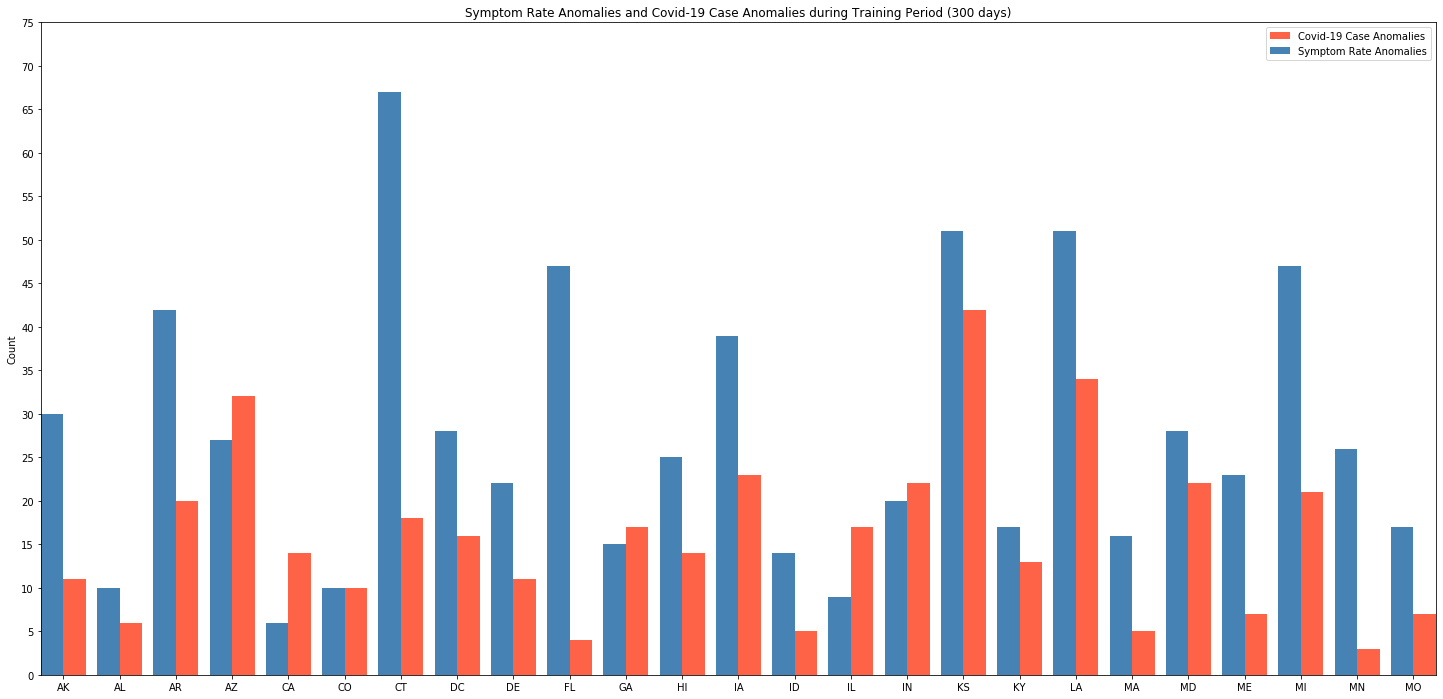

In [53]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(25)
X = [state[3:] for state in STATES[:25]]
ax.bar(_X + 0.2, [int(L_window) for L_window in total_real_anomalies[:25]], width=0.4, color='tomato', align='center', label="Covid-19 Case Anomalies")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP[:25]], width=0.4, color='steelblue', align='center', label="Symptom Rate Anomalies")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 80, 5))
plt.title("Symptom Rate Anomalies and Covid-19 Case Anomalies during Training Period (300 days)")
plt.ylabel("Count")
plt.legend()
plt.show()

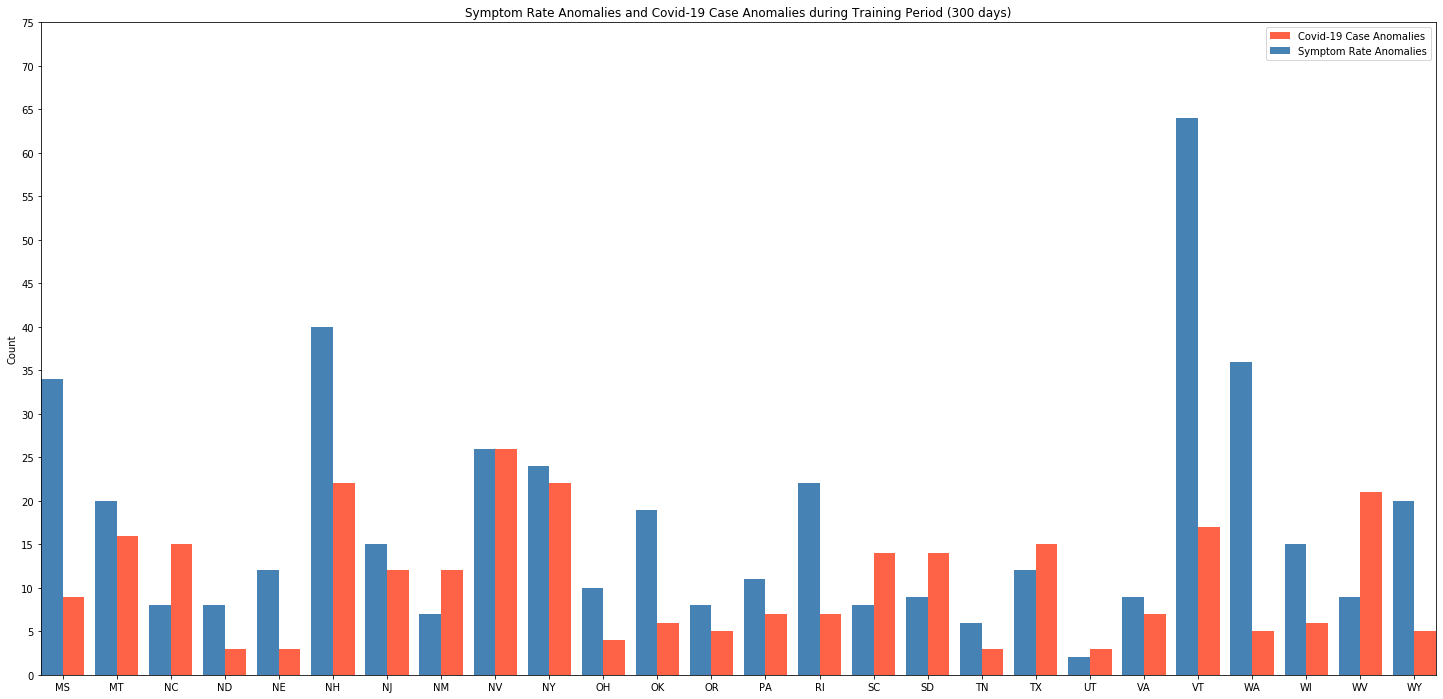

In [54]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(26)
X = [state[3:] for state in STATES[25:]]
ax.bar(_X + 0.2, [int(L_window) for L_window in total_real_anomalies[25:]], width=0.4, color='tomato', align='center', label="Covid-19 Case Anomalies")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP[25:]], width=0.4, color='steelblue', align='center', label="Symptom Rate Anomalies")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 80, 5))
plt.title("Symptom Rate Anomalies and Covid-19 Case Anomalies during Training Period (300 days)")
plt.ylabel("Count")
plt.legend()
plt.show()

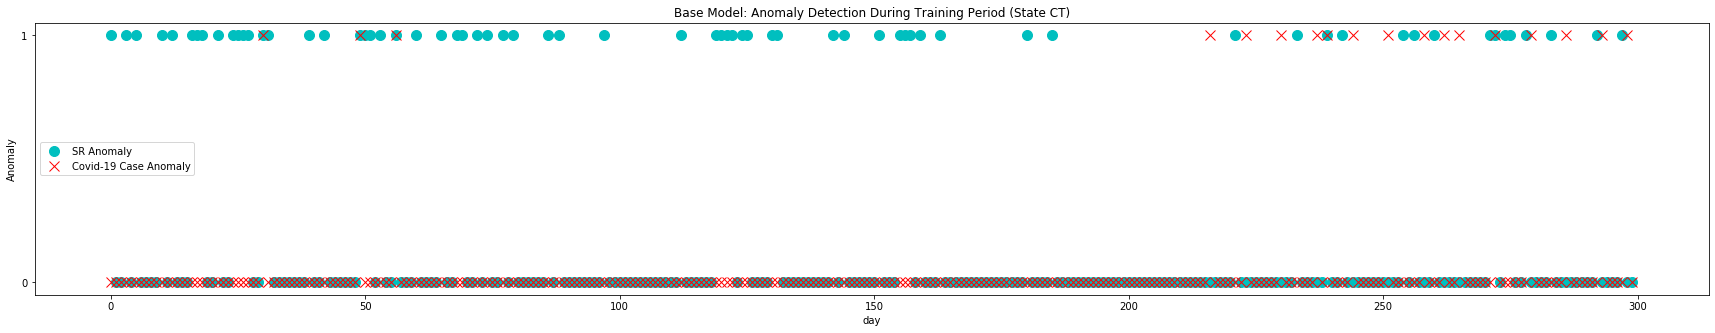

In [42]:
# precision, recall, Fscore
CT = get_target_region_idx("US-CT")
state_th = 0.1
state_lag = 3

L_CT = covid_case_outbreak_detection_all(actual_all, "CT")
L_hat_CT = pred_outbreak_detection(new_delta, L_hat_period_all, state_th)
CT_S, L_window_CT = comparison_all("US-CT", L_CT, L_hat_CT, state_lag)

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Base Model: Anomaly Detection During Training Period (State CT)")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(300)), L_hat_CT.transpose()[CT], marker='o',  markersize=10, color='c', linewidth=0, label="SR Anomaly")
ax.plot(np.array(range(300)), L_window_CT, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
ax.legend(loc="center left")

# Extra Experiment: 2dp TH

TH has 2 decimal places

In [ ]:
# return TP_FP, FN, precision, recall, Fscore
TH_EXP4 = np.arange(0,2,0.01)
lag_EXP4 = np.arange(0,31)
final_best_th_lag_EXP4 = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag_EXP4 = np.zeros(2)
    best_lag_EXP4 = 0
    best_f_score_EXP4 = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all, target)
    for idx_th, th in enumerate(TH_EXP4):
        for idx_l, l in enumerate(lag_EXP4):   
            
            L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, th)
            all_S, L_window = comparison_all(state, L, L_hat, l)
            metr = metrics(all_S, L_window)
            
            if metr[4] > best_f_score_EXP4:
                best_th_lag_EXP4[0] = th
                best_th_lag_EXP4[1] = l
                best_f_score_EXP4 = metr[4]
                
    final_best_th_lag_EXP4[idx_s] = best_th_lag_EXP4

In [56]:
state_TP_FP_EXP4 = np.zeros((NUM_STATES,2))
state_FN_EXP4 = np.zeros(NUM_STATES)
state_fscore_EXP4 = np.zeros(NUM_STATES)
state_precision_EXP4 = np.zeros(NUM_STATES)
state_recall_EXP4 = np.zeros(NUM_STATES)

total_real_anomalies_EXP4 = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L = covid_case_outbreak_detection_all(actual_all, target)
            
    L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, final_best_th_lag_EXP4[idx_s][0])
    
    all_S, L_window = comparison_all(state, L, L_hat, int(final_best_th_lag_EXP4[idx_s][1]))
    total_real_anomalies_EXP4[idx_s] = np.sum(L_window)
    metr = metrics(all_S, L_window)
    
    state_TP_FP_EXP4[idx_s] = metr[0]
    state_FN_EXP4[idx_s] = metr[1]
    state_precision_EXP4[idx_s] = metr[2]
    state_recall_EXP4[idx_s] = metr[3]
    state_fscore_EXP4[idx_s] = metr[4]

In [57]:
np.savetxt("state_TP_FP_EXP4.csv", state_TP_FP_EXP4, delimiter=",")
np.savetxt("state_FN_EXP4.csv", state_FN_EXP4, delimiter=",")
np.savetxt("state_precision_EXP4.csv", state_precision_EXP4, delimiter=",")
np.savetxt("state_recall_EXP4.csv", state_recall_EXP4, delimiter=",")
np.savetxt("state_fscore_EXP4.csv", state_fscore_EXP4, delimiter=",")
np.savetxt("total_real_anomalies_EXP4.csv", total_real_anomalies_EXP4, delimiter=",")
np.savetxt("state_best_th_lag_EXP4.csv", final_best_th_lag_EXP4, delimiter=",")

In [58]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(NUM_STATES)
X = [state[3:] for state in STATES]
ax.bar(_X + 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP], width=0.4, color='tomato', align='center', label="Orginal")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_EXP4], width=0.4, color='steelblue', align='center', label="New")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 80, 5))
plt.title("Symptom Rate Anomalies (Original) and Symptom Rate Anomalies (Smaller TH)")
plt.ylabel("Count")
plt.legend()
plt.show()

# DEBUGGING

Can remain commented out

In [59]:
# new_delta_debug = np.concatenate((new_delta, new_delta_Jan21), axis=0)
# L_hat_debug_period = new_delta_debug.shape[0]
# print(L_hat_debug_period)
# print(new_delta.shape)

In [60]:
# for state in STATES: 
#     best_th_lag = np.zeros(2)
#     best_lag = 0
#     best_f_score = 0
    
#     target = get_target_region_idx(state) 
#     L_debug = pred_outbreak_detection(new_delta, L_hat_period_all, 1).transpose()[target]
    
#     L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, 1)
#     all_S, L_window = comparison_all(state, L_debug, L_hat, 0)

#     metr = metrics(all_S, L_window)
#     if metr[4] > best_f_score:
#         best_th_lag[0] = th
#         best_th_lag[1] = l
#         best_f_score = metr[4]
#     print(state + " " + str(best_f_score))

In [61]:
# for state in STATES: 
#     best_th_lag = np.zeros(2)
#     best_lag = 0
#     best_f_score = 0
    
#     target = get_target_region_idx(state)
#     L_debug = pred_outbreak_detection(new_delta_debug, L_hat_debug_period, 1).transpose()[target]
    
#     for idx_th, th in enumerate(TH):
#         for idx_l, l in enumerate(lag):   

#             L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, th)
#             all_S, L_window = comparison_all(state, L_debug, L_hat, l)

#             metr = metrics(all_S, L_window)
#             if metr[4] > best_f_score:
#                 best_th_lag[0] = th
#                 best_th_lag[1] = l
#                 best_f_score = metr[4]
    
#     print(state + " " + str(best_f_score) + " lag " + str(best_th_lag[1]) + " th " + str(best_th_lag[0]))

In [62]:
# for state in ["US-IL"]: 
#     best_th_lag = np.zeros(2)
#     best_lag = 0
#     best_f_score = 0
    
#     target = get_target_region_idx(state)
#     L_debug = pred_outbreak_detection(new_delta_debug, L_hat_debug_period, 1).transpose()[target]
    
#     for idx_th, th in enumerate([1.0]):
#         for idx_l, l in enumerate([0]):   
#             print("TH lag " + str(th) + " , " + str(l))
            
#             L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, 1.0)
#             all_S, L_window = comparison_all(state, L_debug, L_hat, 0)

#             metr = metrics(all_S, L_window)
#             print("best", best_f_score)
#             print("curr", metr[4])
#             if metr[4] > best_f_score:
#                 best_th_lag[0] = th
#                 best_th_lag[1] = l
#                 best_f_score = metr[4]
#     print(state + " " + str(best_f_score) + " lag " + str(best_th_lag[1]) + " th " + str(best_th_lag[0]))

# Analysing Base Model Results

## CT

(array([8., 7.]), 9.0, 0.5333333333333333, 0.47058823529411764, 0.5)


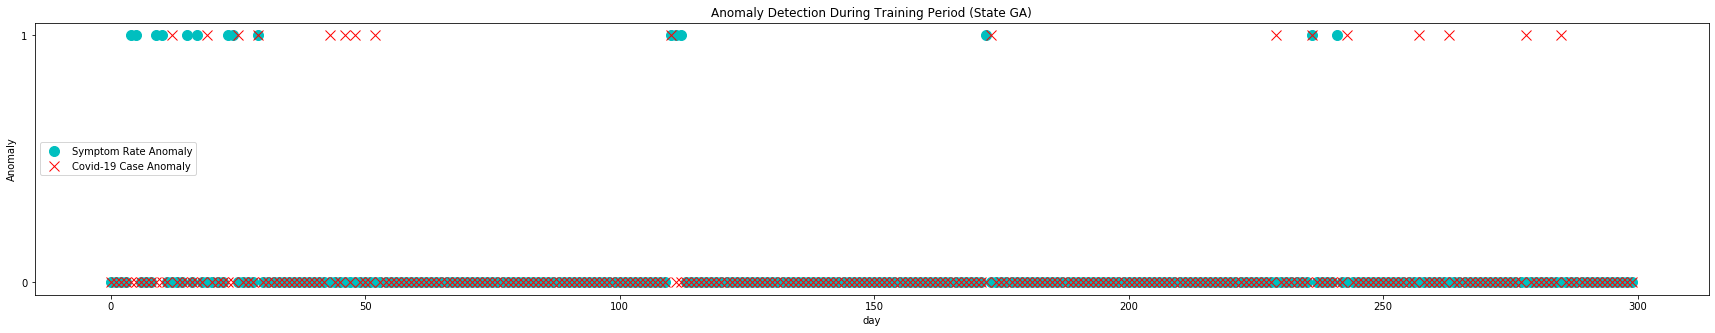

In [38]:
# precision, recall, Fscore
state_lag = 12
state_th = 0.6
CT = get_target_region_idx("US-GA")

L_CT = covid_case_outbreak_detection_all(actual_all, "GA")

L_hat_CT = pred_outbreak_detection(new_delta, L_hat_period_all, state_th)
CT_S, L_window_CT = comparison_all("US-GA", L_CT, L_hat_CT, state_lag)

print(metrics(CT_S, L_window_CT))

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)

ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection During Training Period (State GA)")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(300)),L_hat_CT.transpose()[CT], marker='o',  markersize=10, color='c', linewidth=0, label="Symptom Rate Anomaly")
ax.plot(np.array(range(300)),L_window_CT, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
ax.legend(loc="center left")

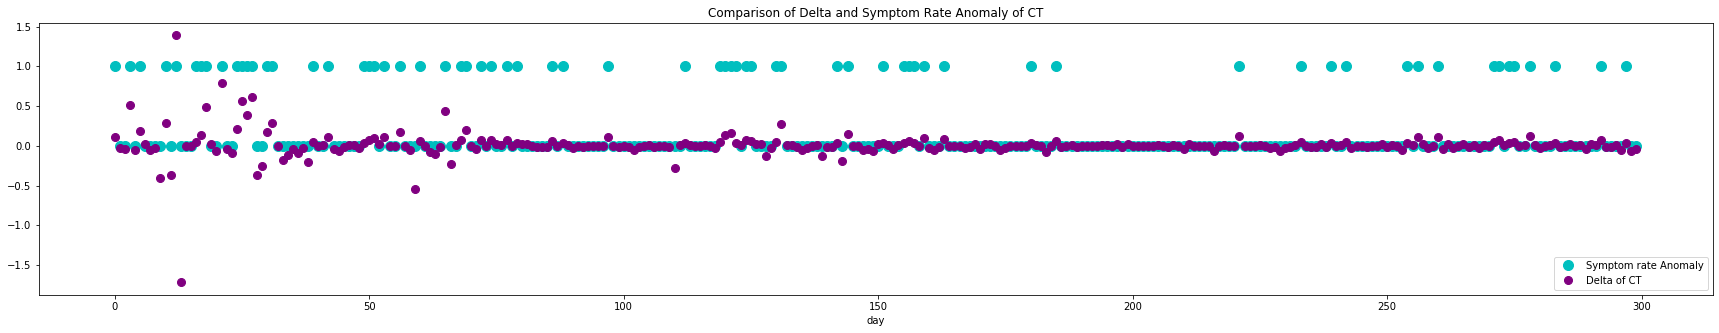

In [31]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_xlabel("day")
ax.set_title("Comparison of Delta and Symptom Rate Anomaly of CT")
ax.plot(np.array(range(300)),L_hat_CT.transpose()[CT], marker='o',  markersize=10, color='c', linewidth=0, label="Symptom rate Anomaly")
ax.plot(np.array(range(300)),new_delta.transpose()[CT], marker='o',  markersize=8, color='purple', linewidth=0, label="Delta of CT")
ax.legend(loc="lower right")

Text(0, 0.5, 'F score')

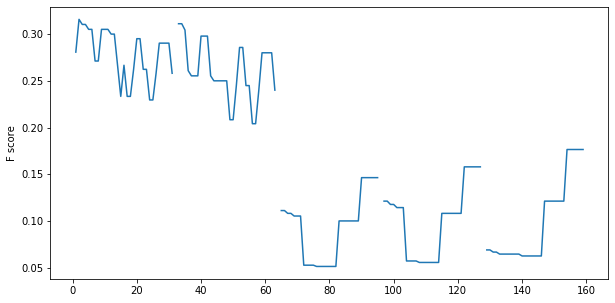

In [77]:
f_score = []
for th in np.arange(0.3, 1.3, 0.2):
    f_score.append(np.nan)
    for l in range(31):
        L_hat_CT = pred_outbreak_detection(new_delta, L_hat_period_all, th)
        CT_S, L_window_CT = comparison_all("US-CT", L_CT, L_hat_CT, l)
        metr_CT = metrics(CT_S, L_window_CT)
        f_score.append(metr_CT[4])
plt.figure(figsize=(10,5))
plt.plot(f_score)
plt.ylabel("F score")

## NC

(array([8., 0.]), 7.0, 1.0, 0.5333333333333333, 0.6956521739130436)


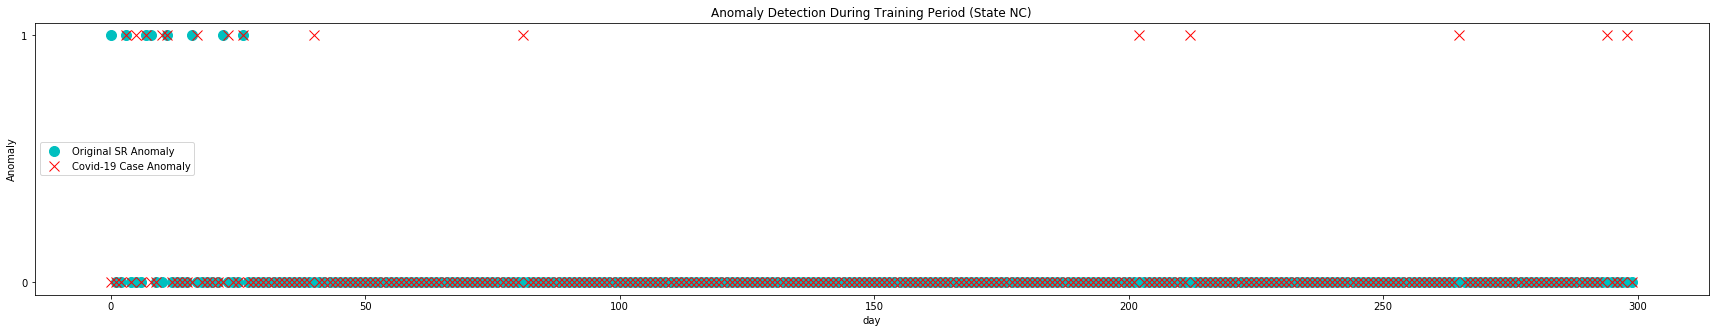

In [243]:
# precision, recall, Fscore
state_lag = 0
state_th = 1.9
NC = get_target_region_idx("US-NC")

L_NC = covid_case_outbreak_detection_all(actual_all, "NC")

L_hat_NC = pred_outbreak_detection(new_delta, L_hat_period_all, state_th)
NC_S, L_window_NC = comparison_all("US-NC", L_NC, L_hat_NC, state_lag)

print(metrics(NC_S, L_window_NC))

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)

ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection During Training Period (State NC)")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(300)),L_hat_NC.transpose()[NC], marker='o',  markersize=10, color='c', linewidth=0, label="Original SR Anomaly")
ax.plot(np.array(range(300)),L_window_NC, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
ax.legend(loc="center left")

## VT

(array([1., 7.]), 17.0, 0.125, 0.05555555555555555, 0.07692307692307691)


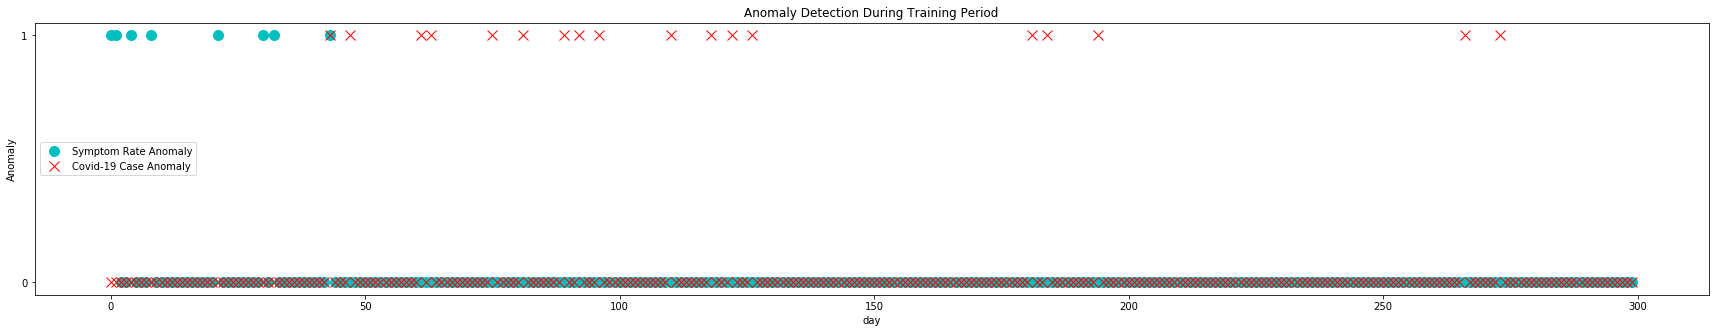

In [78]:
# precision, recall, Fscore
state_lag = 28
state_th = 1.1
VT = get_target_region_idx("US-VT")

L_VT = covid_case_outbreak_detection_all(actual_all, "VT")

L_hat_VT = pred_outbreak_detection(new_delta, L_hat_period_all, state_th)
VT_S, L_window_VT = comparison_all("US-VT", L_VT, L_hat_VT, state_lag)

print(metrics(VT_S, L_window_VT))

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)

ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection During Training Period")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(300)),L_hat_VT.transpose()[VT], marker='o',  markersize=10, color='c', linewidth=0, label="Symptom Rate Anomaly")
ax.plot(np.array(range(300)),L_window_VT, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
ax.legend(loc="center left")

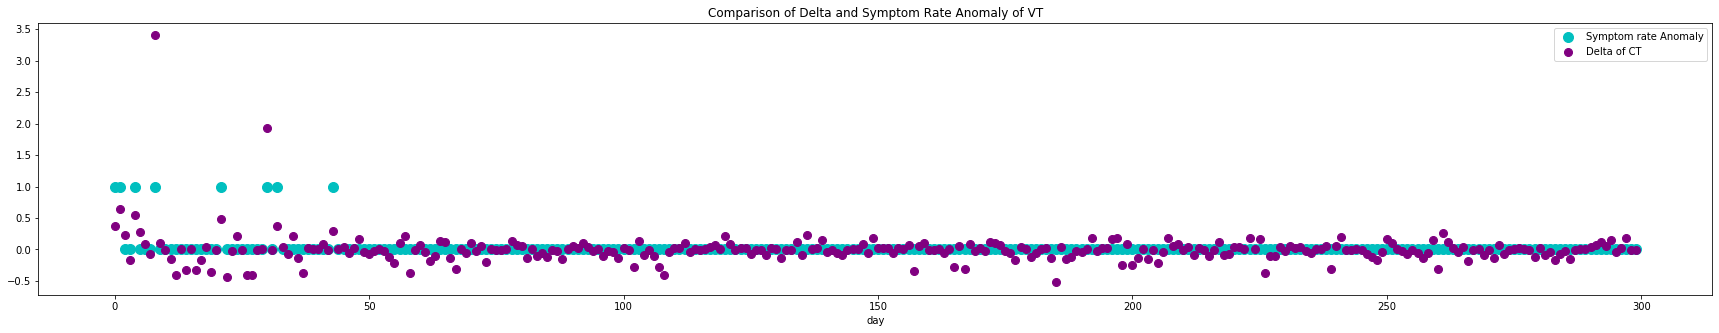

In [79]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_xlabel("day")
ax.set_title("Comparison of Delta and Symptom Rate Anomaly of VT")
ax.plot(np.array(range(300)),L_hat_VT.transpose()[VT], marker='o',  markersize=10, color='c', linewidth=0, label="Symptom rate Anomaly")
ax.plot(np.array(range(300)),new_delta.transpose()[VT], marker='o',  markersize=8, color='purple', linewidth=0, label="Delta of CT")
ax.legend(loc="upper right")

Text(0, 0.5, 'F score')

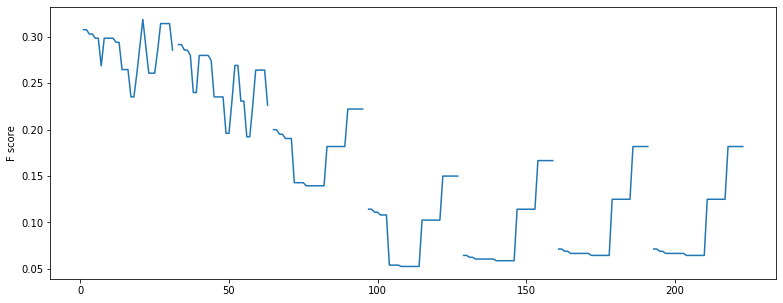

In [80]:
f_score = []
for th in np.arange(0.2, 1.6, 0.2):
    f_score.append(np.nan)
    for l in range(31):
        L_hat_CT = pred_outbreak_detection(new_delta, L_hat_period_all, th)
        CT_S, L_window_CT = comparison_all("US-CT", L_CT, L_hat_CT, l)
        metr_CT = metrics(CT_S, L_window_CT)
        f_score.append(metr_CT[4])
plt.figure(figsize=(13,5))
plt.plot(f_score)
plt.ylabel("F score")

# Exploring the idea of "False Anomalies"

Covid-19 Case anomalies that have small absolute number of cases. Eg. day1 = 1 case, day2 = 3 cases => 300% increase from day 1 to day 2 may result in day2 being classified as having a Covid-19 case anomaly however the number of cases is in actuality, small

In [64]:
# # Histogram purposes
# def covid_case_outbreak_detection_hist(X, target_region, minimum):
#     X_target = X[X.state == target_region].drop(['date', 'state'], axis=1).to_numpy().flatten()
#     X_target[X_target < 1] = 1
#     assert np.any(X_target < 1) == False, "Actual Cases < 1"
#     period = len(X_target) 
#     C = np.zeros(period)
#     for idx, X_day in enumerate(X_target):
#         if idx == 0:
#             continue  
#         Cd = np.divide(np.subtract(X_day, X_target[idx-1]), X_target[idx-1])
#         C[idx] = Cd   
#     temp = np.copy(C)
#     std_C = np.std(C)
#     temp[temp > (3 * std_C)] = 0
#     std_C = np.std(temp)
#     assert std_C != 0, "Std C is 0"
#     L_score = C > (2 * std_C)
#     L_score = L_score.astype(int)
#     anomaly_cases = np.array([X_target[idx] for idx, l in enumerate(L_score) if l == 1 and X_target[idx] < minimum])
#     return anomaly_cases

# # FOR ALL STATES
# small_anoms = np.zeros(NUM_STATES)
# actual_case_count_training = np.zeros(NUM_STATES)
# for idx_s, state in enumerate(STATES):
#     actual_case_count_training[idx_s] = np.sum(covid_case_outbreak_detection_all(actual_all, state[3:]))
#     small_anoms[idx_s] = len(covid_case_outbreak_detection_hist(actual_all, state[3:], 50))

# fig = plt.figure(figsize=(25, 12))
# ax = fig.add_subplot(111)
# _X = np.arange(NUM_STATES)
# X = [state[3:] for state in STATES]
# ax.bar(_X + 0.2, small_anoms, width=0.4, color='tomato', align='center', label="False Anomalies")
# ax.bar(_X - 0.2, actual_case_count_training, width=0.4, color='steelblue', align='center', label="Anomalies")
# ax.autoscale(tight=True)
# plt.xticks(_X, X)
# plt.title("False Anomalies and Covid-19 Case Anomalies during Training Period")
# plt.ylabel("Count")
# plt.legend()
# plt.show()

# Experimentation 3: Linear Correlation

From 7 March 2020 - 31 Dec 2020

In [81]:
# symptoms = F[(F.date >= '2020-03-07') & (F.date <= '2020-12-31')]
# # (Symptom, Period)
# symptoms_aggregated = symptoms.groupby('date').sum().to_numpy().transpose()

# cases_for_corr_agg = actual_cases[(actual_cases.date >= '2020-03-07') & (actual_cases.date <= '2020-12-31')]
# cases_for_corr_agg = cases_for_corr_agg.groupby('date').sum().to_numpy()
# scaler = MinMaxScaler(feature_range=(0, 1))
# normalised_cases = scaler.fit_transform(cases_for_corr_agg).flatten()

# corr_agg = []
# for idx_s, symp in enumerate(SYMP_LIST):
#     corr_agg.append(np.array(stats.pearsonr(symptoms_aggregated[idx_s], normalised_cases)))

In [66]:
# fig, ax = plt.subplots(figsize=(10,7))

# # Example data
# y_pos = np.arange(NUM_SYMP)
# ax.barh(y_pos, [c[0] for c in corr_agg], align='center')
# ax.set_yticks(y_pos)
# ax.set_yticklabels([s[8:] for s in SYMP_LIST])
# ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Pearson Correlation, r')
# ax.set_title('Pearson Correlation of Aggregated Symptom Rates and Aggregated New Covid-19 Cases')

In [67]:
# fig, ax = plt.subplots(figsize=(10,7))
# x = symptoms_aggregated[-6]
# ax.scatter(x, normalised_cases)
# ax.set_xlabel('Aggregated Symptom Rate: Clouding of Consciousness')
# ax.set_ylabel('Normalized Daily Covid-19 Cases')
# ax.set_title('Symptom Rate: Clouding of Consciousness')
# z = np.polyfit(x, normalised_cases, 1)
# p = np.poly1d(z)
# plt.plot(x,p(x),"r--")
# plt.show()

# Experimentation 7.1: SMOOTHING (Moving Average to Prepare Dataset)

Checking if the data is stationary: 1st Jan - 31 Dec (366 datapoints)

In [25]:
from statsmodels.tsa.stattools import adfuller
print(" > Is the data stationary ?")
dftest = adfuller(new_delta.transpose()[0], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value =  {:.8f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -5.628
P-value =  0.00000110
Critical values :
	1%: -3.4531816058796143 - The data is  stationary with 99% confidence
	5%: -2.871593390724642 - The data is  stationary with 95% confidence
	10%: -2.5721268156511536 - The data is  stationary with 90% confidence


### w = 3

Loading Data

In [44]:
Mar_smooth = load('results/smoothing_delta/sMar20_01_31.npy')
Apr_smooth = load('results/smoothing_delta/sApr20_01_30.npy')
May_smooth = load('results/smoothing_delta/sMay20_01_31.npy')
Jun_smooth = load('results/smoothing_delta/sJun20_01_30.npy')
Jul_smooth = load('results/smoothing_delta/sJul20_01_31.npy')
Aug_smooth = load('results/smoothing_delta/sAug20_01_31.npy')
Sept_smooth = load('results/smoothing_delta/sSept20_01_30.npy')
Oct_smooth = load('results/smoothing_delta/sOct20_01_31.npy')
Nov_smooth = load('results/smoothing_delta/sNov20_01_30.npy')
Dec_smooth = load('results/smoothing_delta/sDec20_01_31.npy')

In [45]:
new_delta_sMar = new_delta_mat(Mar_smooth, period_31, 4, 7)[6:]
new_delta_sApr = new_delta_mat(Apr_smooth, period_30, 4, 7)
new_delta_sMay = new_delta_mat(May_smooth, period_31, 4, 7)
new_delta_sJun = new_delta_mat(Jun_smooth, period_30, 4, 7)
new_delta_sJul = new_delta_mat(Jul_smooth, period_31, 4, 7)
new_delta_sAug = new_delta_mat(Aug_smooth, period_31, 4, 7)
new_delta_sSept = new_delta_mat(Sept_smooth, period_30, 4, 7)
new_delta_sOct = new_delta_mat(Oct_smooth, period_31, 4, 7)
new_delta_sNov = new_delta_mat(Nov_smooth, period_30, 4, 7)
new_delta_sDec = new_delta_mat(Dec_smooth, period_31, 4, 7)
# new_delta_Jan21 = new_delta_mat(data_Jan21, period_31, 4, 7)
# new_delta_Feb21 = new_delta_mat(data_Feb21, period_feb, 4, 7)

# Joining of new delta: 7th Mar - Jan 2021
new_Sdelta = np.concatenate((new_delta_sMar, new_delta_sApr), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sMay), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sJun), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sJul), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sAug), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sSept), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sOct), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sNov), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sDec), axis=0)

Comparison of delta original and delta smooth (US-CA, w=3)

Text(0.5, 1.0, 'Comparison of delta of original Symptom Rates and smoothed Symptom Rates (US-CT, w=3)')

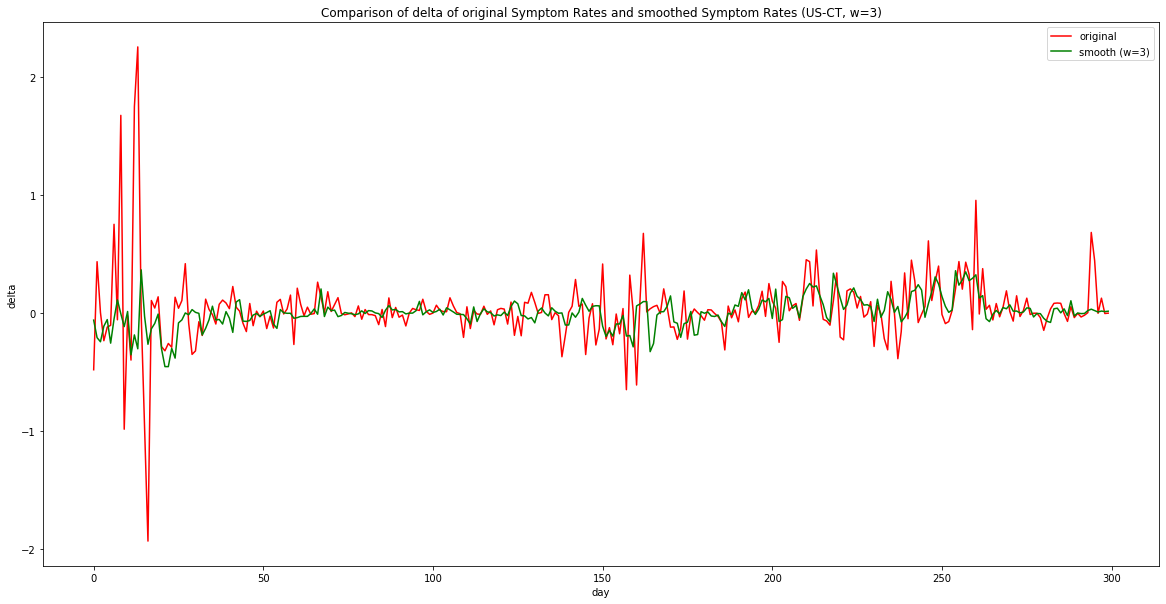

In [48]:
fig = plt.figure(figsize=(20, 10))
plt.plot(new_delta.transpose()[11], color='r', label="original")
plt.plot(new_Sdelta.transpose()[11], color='g',label="smooth (w=3)")
plt.legend()
plt.xlabel("day")
plt.ylabel("delta")
plt.title("Comparison of delta of original Symptom Rates and smoothed Symptom Rates (US-CT, w=3)")

Getting F-scores and Metrics

In [49]:
# return TP_FP, FN, precision, recall, Fscore
TH = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
# TH = 0
lag = np.arange(0,31)
state_best_th_lag = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all, target)
    
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   

            L_hat = pred_outbreak_detection(new_Sdelta, L_hat_period_all, th)
            all_S, L_window = comparison_all(state, L, L_hat, l)
            metr = metrics(all_S, L_window)
            
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
                
    state_best_th_lag[idx_s] = best_th_lag
np.save("best_th_lag_smooth.npy", state_best_th_lag)

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [51]:
state_best_th_lag_S = load('best_th_lag_smooth.npy')

state_TP_FP_S = np.zeros((NUM_STATES,2))
state_FN_S = np.zeros(NUM_STATES)
state_fscore_S = np.zeros(NUM_STATES)
state_precision_S = np.zeros(NUM_STATES)
state_recall_S = np.zeros(NUM_STATES)
total_real_anomalies_S = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    
    L_S = covid_case_outbreak_detection_all(actual_all, target)
    L_hat_S = pred_outbreak_detection(new_Sdelta, L_hat_period_all, state_best_th_lag_S[idx_s][0])
    all_S_smooth, L_window_S = comparison_all(state, L_S, L_hat_S, int(state_best_th_lag_S[idx_s][1]))
    
    
    total_real_anomalies_S[idx_s] = np.sum(L_window_S)
    metr = metrics(all_S_smooth, L_window_S)
    
    state_TP_FP_S[idx_s] = metr[0]
    state_FN_S[idx_s] = metr[1]
    state_precision_S[idx_s] = metr[2]
    state_recall_S[idx_s] = metr[3]
    state_fscore_S[idx_s] = metr[4]

In [60]:
state_best_th_lag_S[11]

array([0.3, 1. ])

Saving Results

In [95]:
np.savetxt("state_TP_FP_S.csv", state_TP_FP_S, delimiter=",")
np.savetxt("state_FN_S.csv", state_FN_S, delimiter=",")
np.savetxt("state_precision_S.csv", state_precision_S, delimiter=",")
np.savetxt("state_recall_S.csv", state_recall_S, delimiter=",")
np.savetxt("state_fscore_S.csv", state_fscore_S, delimiter=",")
np.savetxt("total_real_anomalies_S.csv", total_real_anomalies_S, delimiter=",")
np.savetxt("state_best_th_lag_S.csv", state_best_th_lag_S, delimiter=",")

Getting __Non-Smoothed__ Metrics

In [53]:
##NON SMOOTHING
state_best_th_lag_ori = load('best_th_lag_V3.npy')

state_TP_FP_ori = np.zeros((NUM_STATES,2))
state_FN_ori = np.zeros(NUM_STATES)
state_fscore_ori = np.zeros(NUM_STATES)
state_precision_ori = np.zeros(NUM_STATES)
state_recall_ori = np.zeros(NUM_STATES)
total_real_anomalies_ori = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L_ori = covid_case_outbreak_detection_all(actual_all, target)
            
    L_hat_ori = pred_outbreak_detection(new_delta, L_hat_period_all, state_best_th_lag_ori[idx_s][0])
    
    all_S_ori, L_window_ori = comparison_all(state, L_ori, L_hat_ori, int(state_best_th_lag_ori[idx_s][1]))
    
    total_real_anomalies_ori[idx_s] = np.sum(L_window_ori)
    metr_ori = metrics(all_S_ori, L_window_ori)
    
    state_TP_FP_ori[idx_s] = metr_ori[0]
    state_FN_ori[idx_s] = metr_ori[1]
    state_precision_ori[idx_s] = metr_ori[2]
    state_recall_ori[idx_s] = metr_ori[3]
    state_fscore_ori[idx_s] = metr_ori[4]

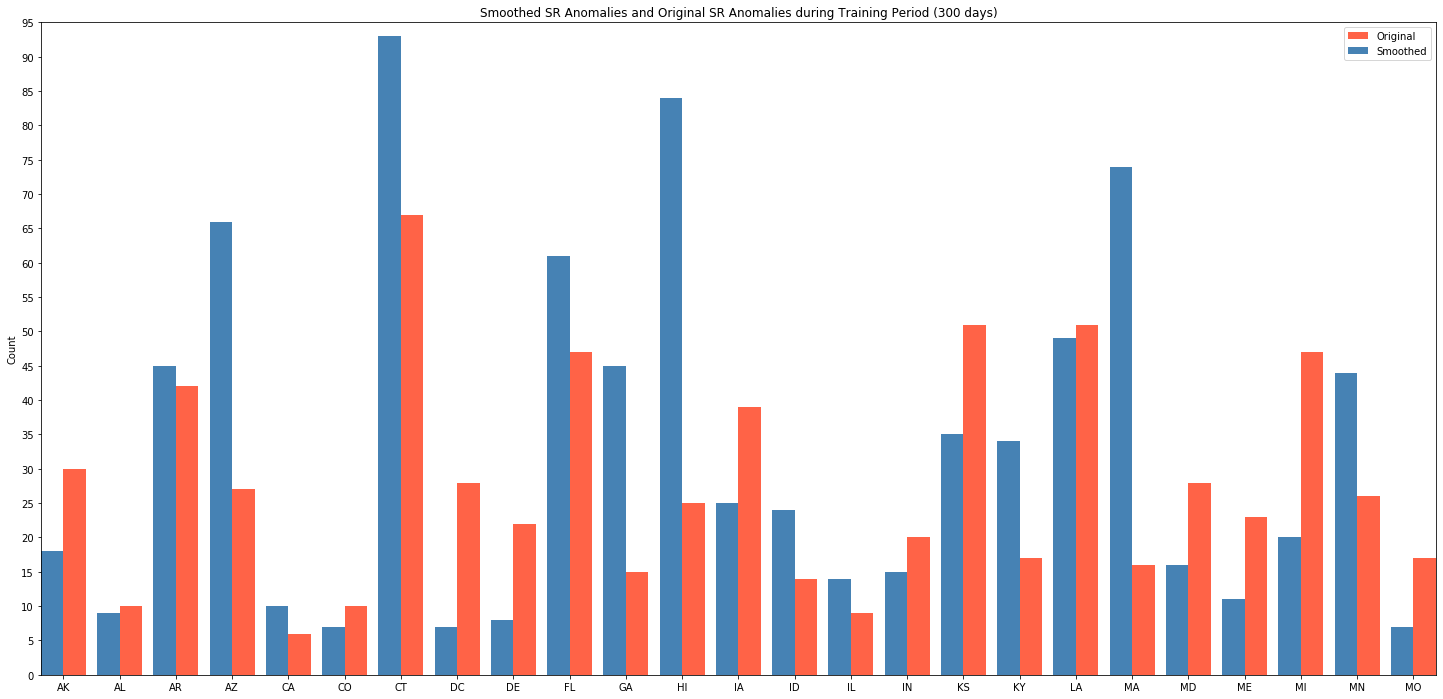

In [31]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(25)
X = [state[3:] for state in STATES[:25]]
ax.bar(_X + 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_ori[:25]], width=0.4, color='tomato', align='center', label="Original")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_S[:25]], width=0.4, color='steelblue', align='center', label="Smoothed")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 100, 5))
plt.title("Smoothed SR Anomalies and Original SR Anomalies during Training Period (300 days)")
plt.ylabel("Count")
plt.legend()
plt.show()

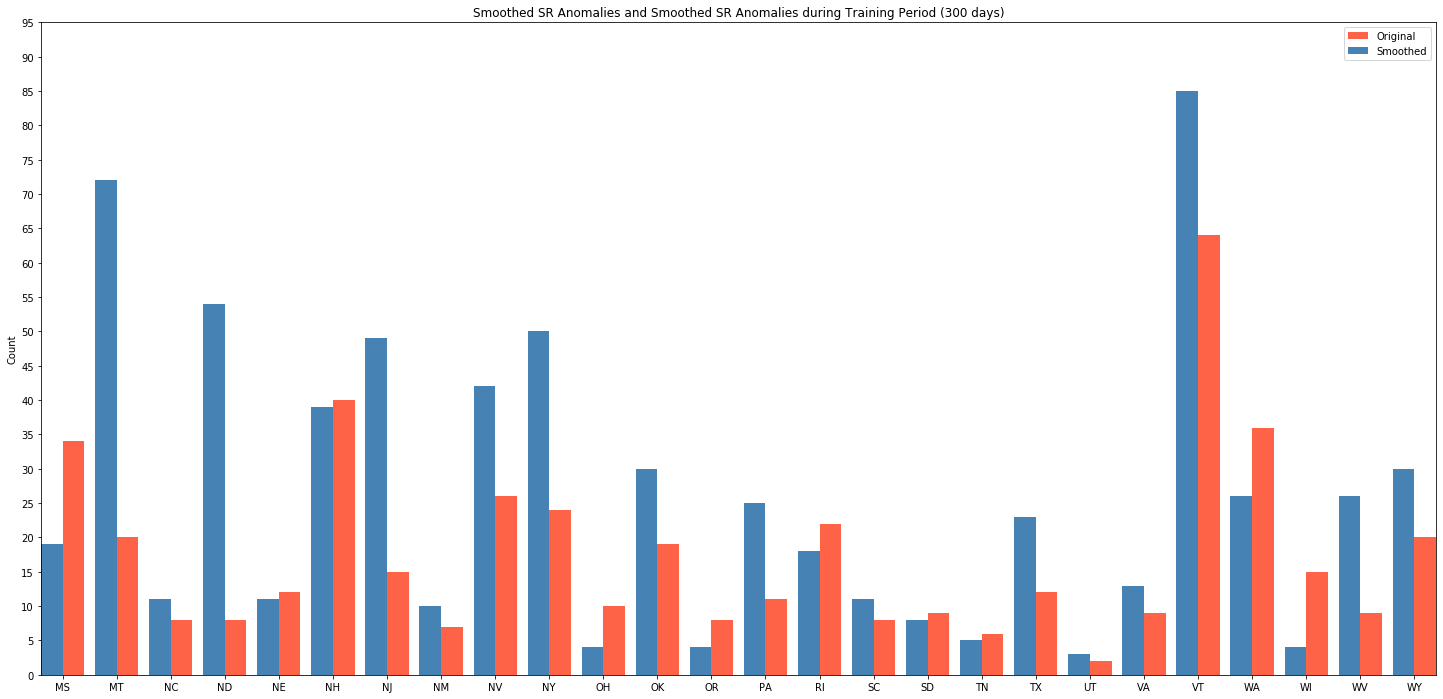

In [32]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(26)
X = [state[3:] for state in STATES[25:]]
ax.bar(_X + 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_ori[25:]], width=0.4, color='tomato', align='center', label="Original")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_S[25:]], width=0.4, color='steelblue', align='center', label="Smoothed")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 100, 5))
plt.title("Smoothed SR Anomalies and Smoothed SR Anomalies during Training Period (300 days)")
plt.ylabel("Count")
plt.legend()
plt.show()

### Smoothing CT

(array([15., 78.]), 7.0, 0.16129032258064516, 0.6818181818181818, 0.2608695652173913)


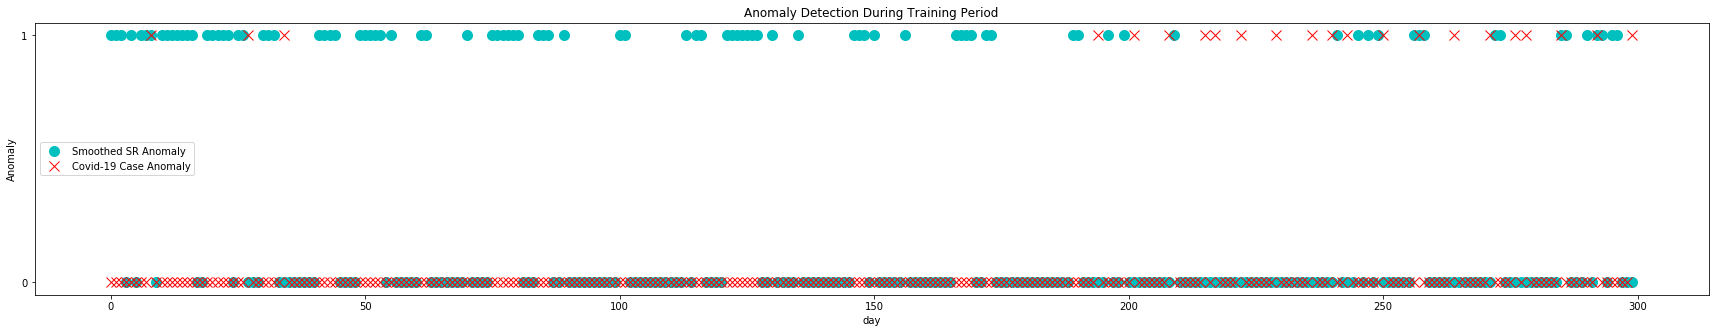

In [39]:
# precision, recall, Fscore
CT = get_target_region_idx("US-CT")
state_lag = 25
state_th = 0.1
L_CT = covid_case_outbreak_detection_all(actual_all, "CT")
L_hat_CT = pred_outbreak_detection(new_Sdelta, L_hat_period_all, state_th)
CT_S, L_window_CT = comparison_all("US-CT", L_CT, L_hat_CT, state_lag)

print(metrics(CT_S, L_window_CT))

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection During Training Period")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(300)), L_hat_CT.transpose()[CT], marker='o',  markersize=10, color='c', linewidth=0, label="Smoothed SR Anomaly")
ax.plot(np.array(range(300)), L_window_CT, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
ax.legend(loc="center left")

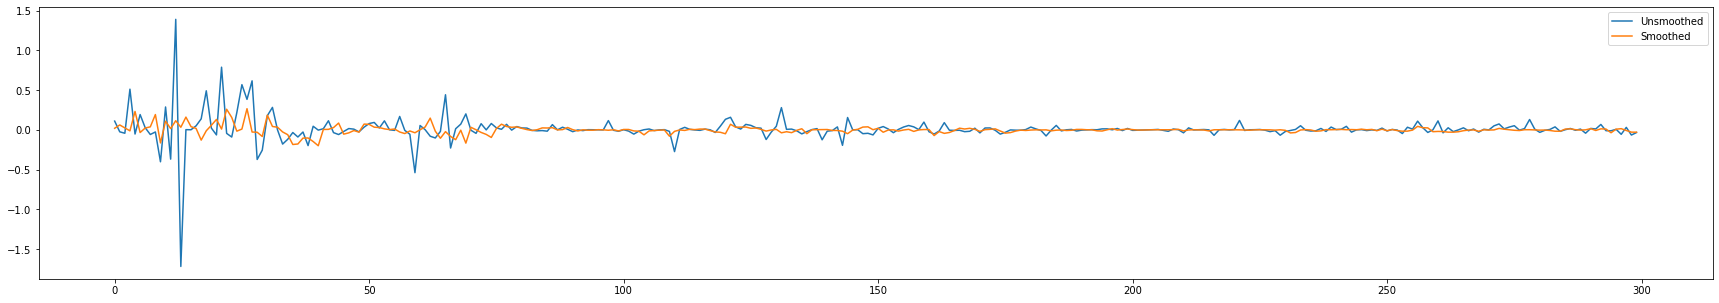

In [40]:
CT = get_target_region_idx("US-CT")
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
plt.plot(new_delta.transpose()[CT], label="Unsmoothed")
plt.plot(new_Sdelta.transpose()[CT], label="Smoothed")
plt.legend()

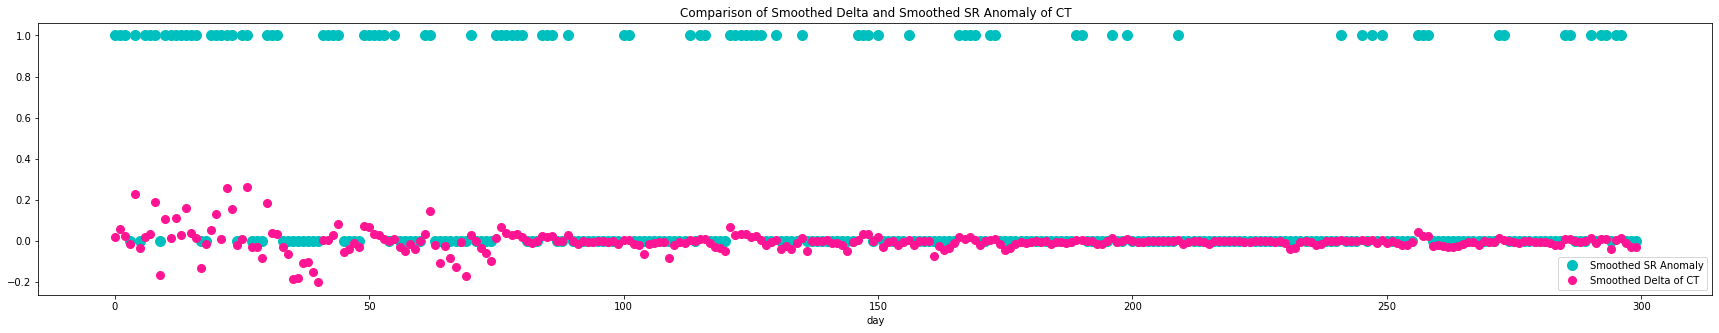

In [41]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_xlabel("day")
ax.set_title("Comparison of Smoothed Delta and Smoothed SR Anomaly of CT")
ax.plot(np.array(range(300)),L_hat_CT.transpose()[CT], marker='o',  markersize=10, color='c', linewidth=0, label="Smoothed SR Anomaly")
ax.plot(np.array(range(300)),new_Sdelta.transpose()[CT], marker='o',  markersize=8, color='deeppink', linewidth=0, label="Smoothed Delta of CT")
ax.legend(loc="lower right")

Delta comparisons

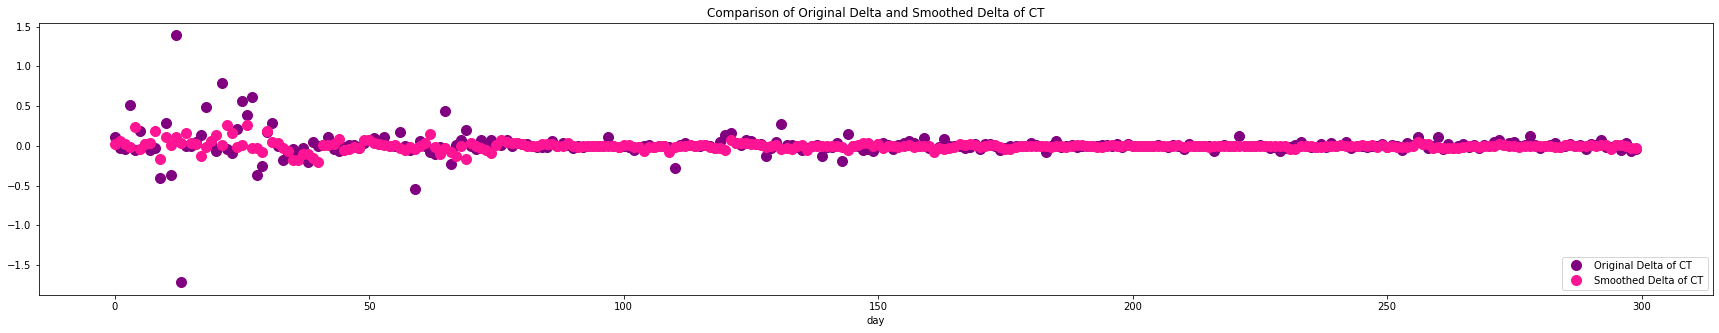

In [42]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_xlabel("day")
ax.set_title("Comparison of Original Delta and Smoothed Delta of CT")
ax.plot(np.array(range(300)),new_delta.transpose()[CT], marker='o',  markersize=10, color='purple', linewidth=0, label="Original Delta of CT")
ax.plot(np.array(range(300)),new_Sdelta.transpose()[CT], marker='o',  markersize=10, color='deeppink', linewidth=0, label="Smoothed Delta of CT")
ax.legend(loc="lower right")

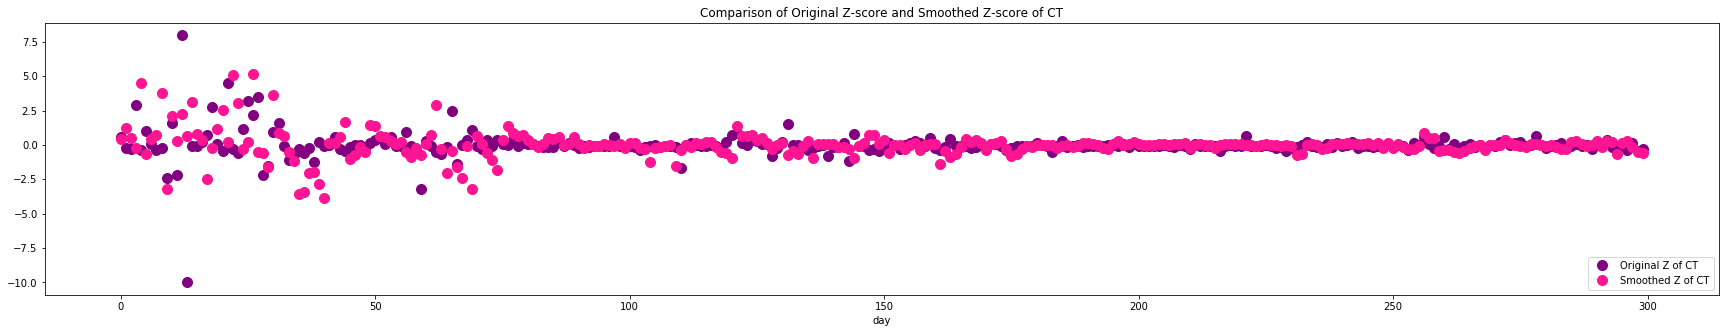

In [55]:
def z_score_smooth(delta, ave, std, period):
    z_score = np.zeros(period)
    for idx_d, delta_day in enumerate(delta):
        z_day = np.divide(np.subtract(delta_day, ave), std)
        z_score[idx_d] = z_day
    return z_score

z_ori = z_score_smooth(new_delta.transpose()[CT], np.mean(new_delta.transpose()[CT]), np.std(new_delta.transpose()[CT]), 300)
z_smooth = z_score_smooth(new_Sdelta.transpose()[CT], np.mean(new_Sdelta.transpose()[CT]), np.std(new_Sdelta.transpose()[CT]), 300)

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_xlabel("day")
ax.set_title("Comparison of Original Z-score and Smoothed Z-score of CT")
ax.plot(np.array(range(300)),z_ori, marker='o',  markersize=10, color='purple', linewidth=0, label="Original Z of CT")
ax.plot(np.array(range(300)),z_smooth, marker='o',  markersize=10, color='deeppink', linewidth=0, label="Smoothed Z of CT")
ax.legend(loc="lower right")

Z-score Histograms

Text(0, 0.5, 'Count')

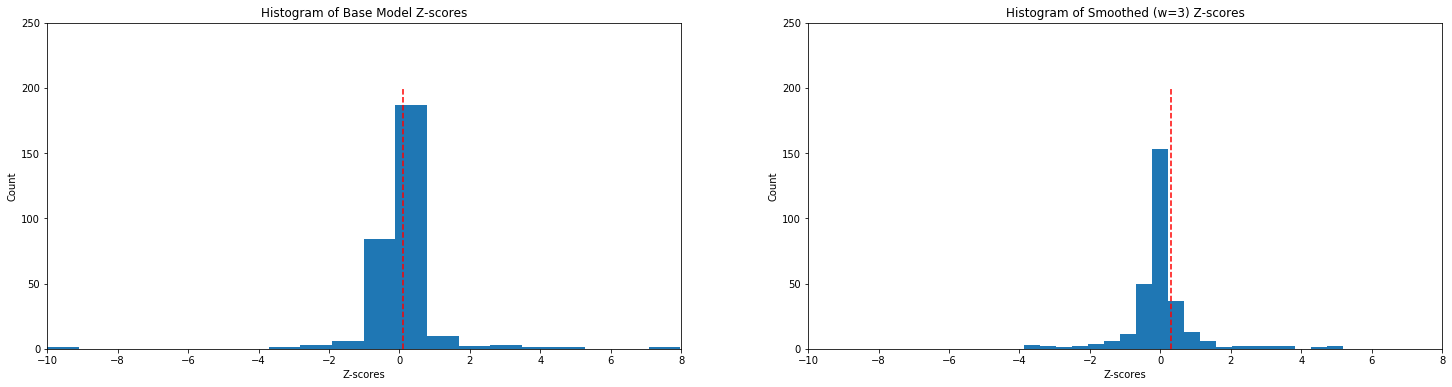

In [63]:
fig = plt.figure(figsize=(25, 6))
ax1 = plt.subplot(121)
ax1.set_xlim(-10,8)
ax1.set_ylim(0,250)
ax1.hist(z_ori, bins=20)
ax1.plot([0.1, 0.1], [0, 200], c='r', linestyle='--')
ax1.set_title("Histogram of Base Model Z-scores")
ax1.set_xlabel("Z-scores")
ax1.set_ylabel("Count")

ax2 = plt.subplot(122)
ax2.set_xlim(-10,8)
ax2.set_ylim(0,250)
ax2.hist(z_smooth, bins=20)
ax2.plot([0.3, 0.3], [0, 200], c='r', linestyle='--')
ax2.set_title("Histogram of Smoothed (w=3) Z-scores")
ax2.set_xlabel("Z-scores")
ax2.set_ylabel("Count")

Average and Std Deviation across 51 states

Text(0, 0.5, 'Std Deviation')

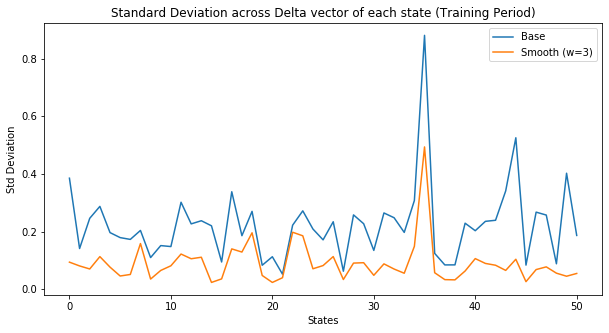

In [86]:
std_base = np.std(new_delta, axis=0)
std_smooth = np.std(new_Sdelta, axis=0)

plt.figure(figsize=(10,5))
plt.plot(std_base, label="Base")
plt.plot(std_smooth, label= "Smooth (w=3)")
plt.legend()
plt.title("Standard Deviation across Delta vector of each state (Training Period)")
plt.xlabel("States")
plt.ylabel("Std Deviation")

Different F-scores for different lags

Text(0, 0.5, 'F score')

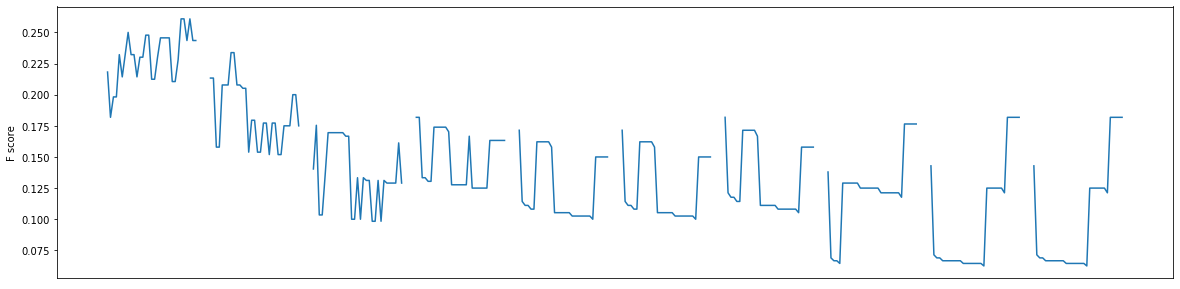

In [122]:
L_CT = covid_case_outbreak_detection_all(actual_all, "CT")
f_score = []

for th in np.arange(0.1, 2.0, 0.2):
    f_score.append(np.nan)
    f_score.append(np.nan)
    f_score.append(np.nan)
    f_score.append(np.nan)
    for l in range(31):
        L_hat_CT_S = pred_outbreak_detection(new_Sdelta, L_hat_period_all, th)
        CT_S, L_window_CT = comparison_all("US-CT", L_CT, L_hat_CT_S, l)
        metr_CT = metrics(CT_S, L_window_CT)
        f_score.append(metr_CT[4])
        
plt.figure(figsize=(20,5))
plt.plot(f_score)
plt.xticks([])
plt.ylabel("F score")

### Smoothing NC

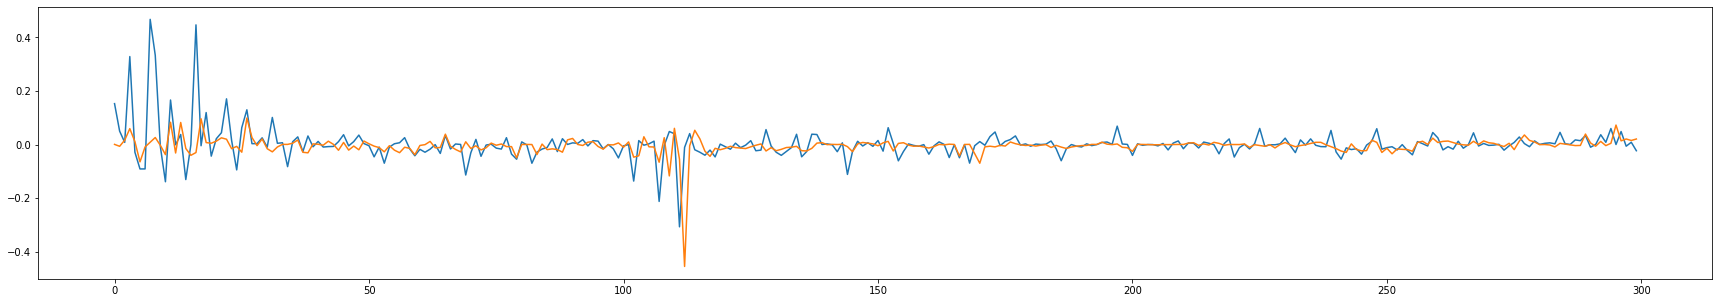

In [238]:
NC = get_target_region_idx("US-NC")
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
plt.plot(new_delta.transpose()[NC])
plt.plot(new_Sdelta.transpose()[NC])

(array([7., 4.]), 4.0, 0.6363636363636364, 0.6363636363636364, 0.6363636363636364)


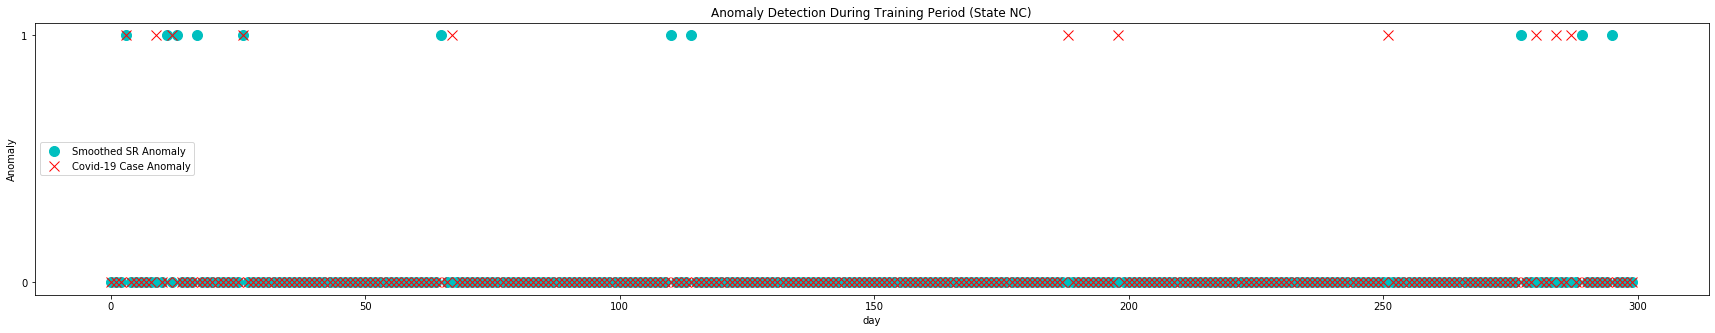

In [239]:
# precision, recall, Fscore
# Smoothing best TH LAG
state_lag = 14
state_th = 1

L_NC = covid_case_outbreak_detection_all(actual_all, "NC")
L_hat_NCsmooth = pred_outbreak_detection(new_Sdelta, L_hat_period_all, state_th)
NC_S, L_window_NCsmooth = comparison_all("US-NC", L_NC, L_hat_NCsmooth, state_lag)

print(metrics(NC_S, L_window_NCsmooth))

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection During Training Period (State NC)")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(300)), L_hat_NCsmooth.transpose()[NC], marker='o',  markersize=10, color='c', linewidth=0, label="Smoothed SR Anomaly")
ax.plot(np.array(range(300)), L_window_NCsmooth, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
ax.legend(loc="center left")

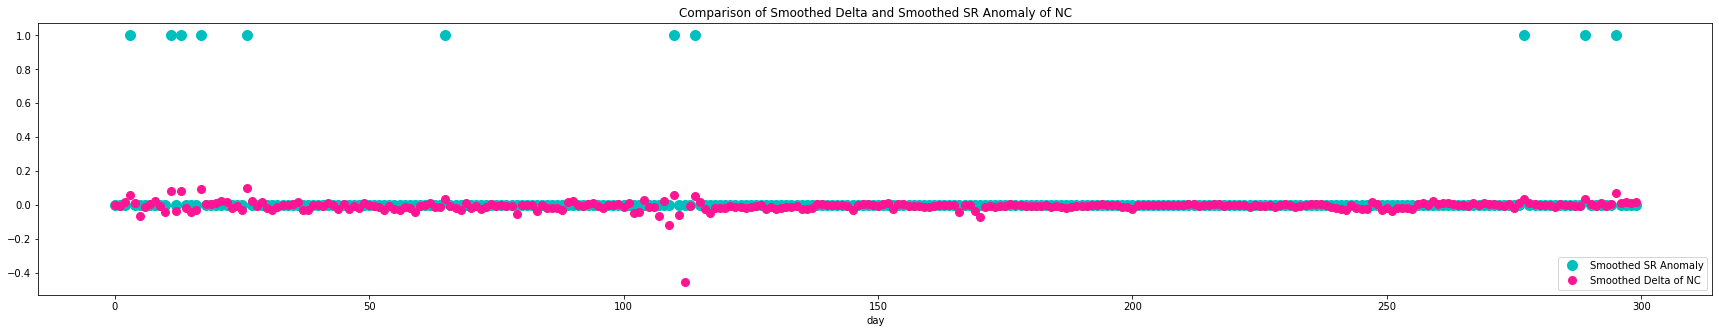

In [245]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_xlabel("day")
ax.set_title("Comparison of Smoothed Delta and Smoothed SR Anomaly of NC")
ax.plot(np.array(range(300)),L_hat_NCsmooth.transpose()[NC], marker='o',  markersize=10, color='c', linewidth=0, label="Smoothed SR Anomaly")
ax.plot(np.array(range(300)),new_Sdelta.transpose()[NC], marker='o',  markersize=8, color='deeppink', linewidth=0, label="Smoothed Delta of NC")
ax.legend(loc="lower right")

## Smoothing w = 7

In [142]:
Mar_smooth7 = load('results/smoothing_delta/w7/sMar20_01_31.npy')
Apr_smooth7 = load('results/smoothing_delta/w7/sApr20_01_30.npy')
May_smooth7 = load('results/smoothing_delta/w7/sMay20_01_31.npy')
Jun_smooth7 = load('results/smoothing_delta/w7/sJun20_01_30.npy')
Jul_smooth7 = load('results/smoothing_delta/w7/sJul20_01_31.npy')
Aug_smooth7 = load('results/smoothing_delta/w7/sAug20_01_31.npy')
Sept_smooth7 = load('results/smoothing_delta/w7/sSept20_01_30.npy')
Oct_smooth7 = load('results/smoothing_delta/w7/sOct20_01_31.npy')
Nov_smooth7 = load('results/smoothing_delta/w7/sNov20_01_30.npy')
Dec_smooth7 = load('results/smoothing_delta/w7/sDec20_01_31.npy')

new_delta_sMar7 = new_delta_mat(Mar_smooth7, period_31, 4, 7)[6:]
new_delta_sApr7 = new_delta_mat(Apr_smooth7, period_30, 4, 7)
new_delta_sMay7 = new_delta_mat(May_smooth7, period_31, 4, 7)
new_delta_sJun7 = new_delta_mat(Jun_smooth7, period_30, 4, 7)
new_delta_sJul7 = new_delta_mat(Jul_smooth7, period_31, 4, 7)
new_delta_sAug7 = new_delta_mat(Aug_smooth7, period_31, 4, 7)
new_delta_sSept7 = new_delta_mat(Sept_smooth7, period_30, 4, 7)
new_delta_sOct7 = new_delta_mat(Oct_smooth7, period_31, 4, 7)
new_delta_sNov7 = new_delta_mat(Nov_smooth7, period_30, 4, 7)
new_delta_sDec7 = new_delta_mat(Dec_smooth7, period_31, 4, 7)

# Joining of new delta: 7th Mar - Jan 2021
new_Sdelta7 = np.concatenate((new_delta_sMar7, new_delta_sApr7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sMay7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sJun7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sJul7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sAug7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sSept7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sOct7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sNov7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sDec7), axis=0)

In [ ]:
# return TP_FP, FN, precision, recall, Fscore
TH = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
lag = np.arange(0,31)
state_best_th_lag7 = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all, target)
    
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   
            
            L_hat7 = pred_outbreak_detection(new_Sdelta7, L_hat_period_all, th)
            all_S7, L_window7 = comparison_all(state, L, L_hat7, l)
            metr = metrics(all_S7, L_window7)
            
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
                
    state_best_th_lag7[idx_s] = best_th_lag
np.save("best_th_lag_smooth7.npy", state_best_th_lag7)

Metrics for Smoothing (w=7)

In [144]:
state_best_th_lag_S7 = load('best_th_lag_smooth7.npy')
state_TP_FP_S7 = np.zeros((NUM_STATES,2))
state_FN_S7 = np.zeros(NUM_STATES)
state_fscore_S7 = np.zeros(NUM_STATES)
state_precision_S7 = np.zeros(NUM_STATES)
state_recall_S7 = np.zeros(NUM_STATES)

total_real_anomalies_S7 = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L_S = covid_case_outbreak_detection_all(actual_all, target)
            
    L_hat_S7 = pred_outbreak_detection(new_Sdelta7, L_hat_period_all, state_best_th_lag_S7[idx_s][0])
    all_S_smooth7, L_window_S7 = comparison_all(state, L_S, L_hat_S7, int(state_best_th_lag_S7[idx_s][1]))
    
    total_real_anomalies_S7[idx_s] = np.sum(L_window_S7)
    metr = metrics(all_S_smooth7, L_window_S7)
    state_TP_FP_S7[idx_s] = metr[0]
    state_FN_S7[idx_s] = metr[1]
    state_precision_S7[idx_s] = metr[2]
    state_recall_S7[idx_s] = metr[3]
    state_fscore_S7[idx_s] = metr[4]

In [251]:
np.savetxt("state_TP_FP_S7.csv", state_TP_FP_S7, delimiter=",")
np.savetxt("state_FN_S7.csv", state_FN_S7, delimiter=",")
np.savetxt("state_precision_S7.csv", state_precision_S7, delimiter=",")
np.savetxt("state_recall_S7.csv", state_recall_S7, delimiter=",")
np.savetxt("state_fscore_S7.csv", state_fscore_S7, delimiter=",")
np.savetxt("total_real_anomalies_S7.csv", total_real_anomalies_S7, delimiter=",")
np.savetxt("state_best_th_lag_S7.csv", state_best_th_lag_S7, delimiter=",")

Plotting symptom rate anomalies of w=3 and w=7 (first 25 states only)

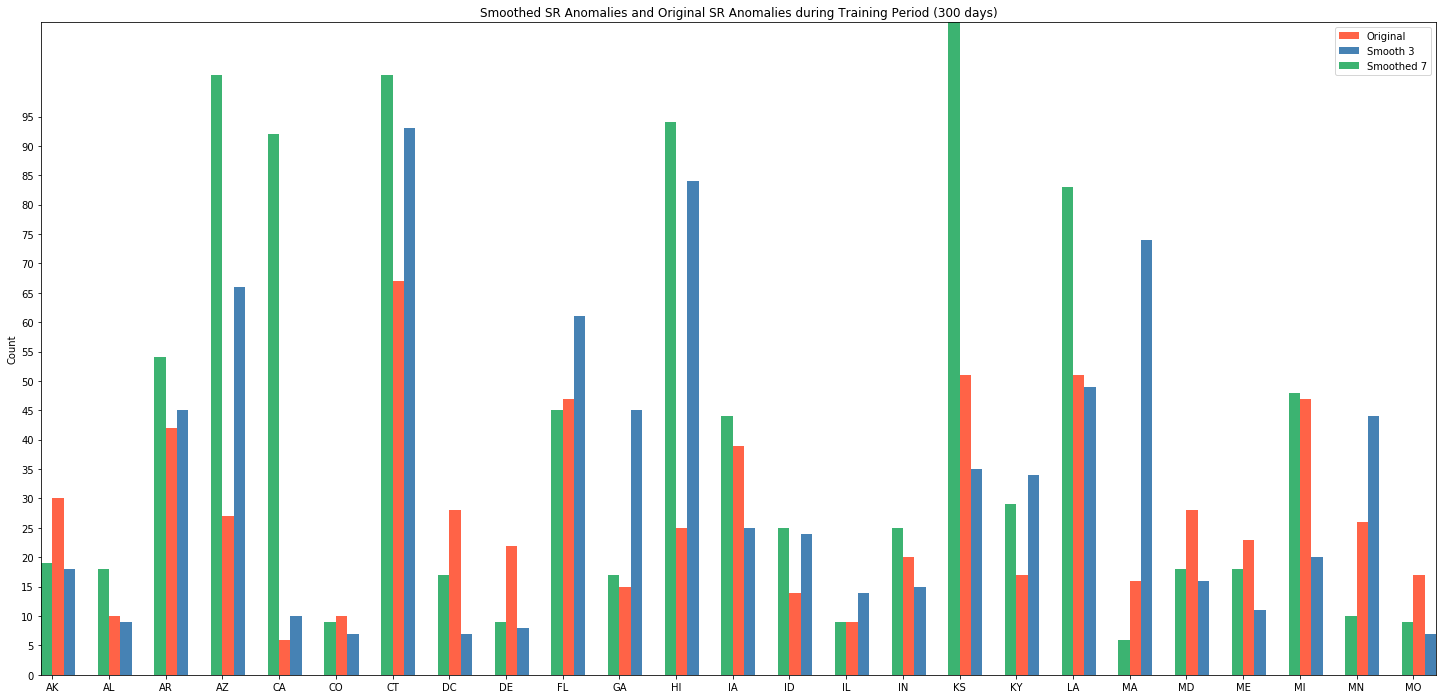

In [157]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(25)
X = [state[3:] for state in STATES[:25]]
ax.bar(_X + 0.1, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_ori[:25]], width=0.2, color='tomato', align='center', label="Original")
ax.bar(_X + 0.3, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_S[:25]], width=0.2, color='steelblue', align='center', label="Smooth 3")
ax.bar(_X - 0.1, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_S7[:25]], width=0.2, color='mediumseagreen', align='center', label="Smoothed 7")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 100, 5))
plt.title("Smoothed SR Anomalies and Original SR Anomalies during Training Period (300 days)")
plt.ylabel("Count")
plt.legend()
plt.show()

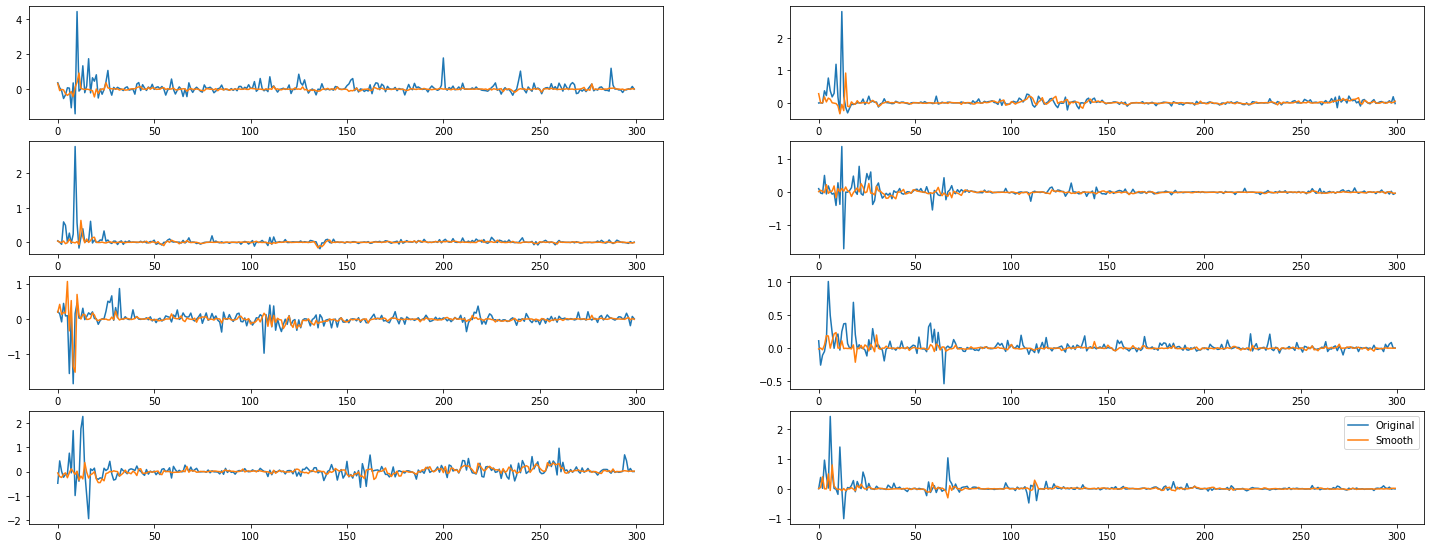

In [178]:
fig = plt.figure(figsize=(25, 12))
plt.subplot(521)
plt.plot(new_delta.transpose()[0], label="Original")
plt.plot(new_Sdelta.transpose()[0], label="Smooth")
plt.subplot(522)
plt.plot(new_delta.transpose()[4], label="Original")
plt.plot(new_Sdelta.transpose()[4], label="Smooth")
plt.subplot(523)
plt.plot(new_delta.transpose()[5], label="Original")
plt.plot(new_Sdelta.transpose()[5], label="Smooth")
plt.subplot(524)
plt.plot(new_delta.transpose()[6], label="Original")
plt.plot(new_Sdelta.transpose()[6], label="Smooth")
plt.subplot(525)
plt.plot(new_delta.transpose()[7], label="Original")
plt.plot(new_Sdelta.transpose()[7], label="Smooth")
plt.subplot(526)
plt.plot(new_delta.transpose()[8], label="Original")
plt.plot(new_Sdelta.transpose()[8], label="Smooth")
plt.subplot(527)
plt.plot(new_delta.transpose()[11], label="Original")
plt.plot(new_Sdelta.transpose()[11], label="Smooth")
plt.subplot(528)
plt.plot(new_delta.transpose()[24], label="Original")
plt.plot(new_Sdelta.transpose()[24], label="Smooth")
plt.legend()

Covid-19 Case Anomalies For States Corresponding to Graph above

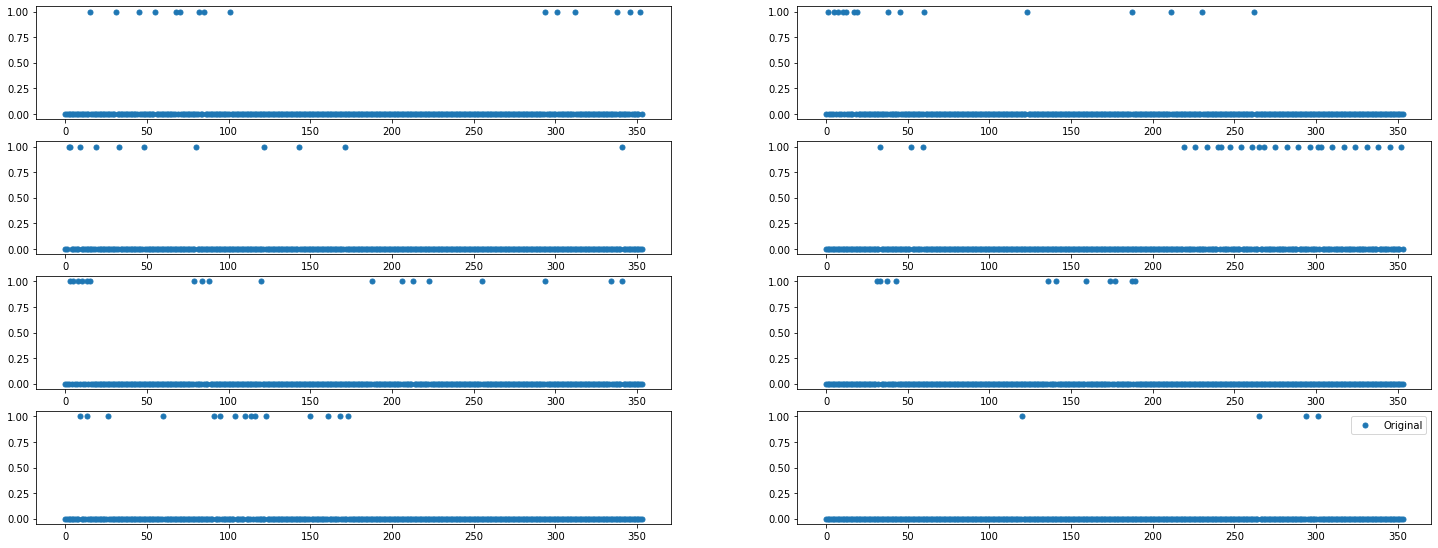

In [191]:
fig = plt.figure(figsize=(25, 12))
plt.subplot(521)
plt.plot(covid_case_outbreak_detection_all(actual_all, "AK"), linewidth=0, marker='o',  markersize=5,label="Original")
# plt.plot(new_Sdelta.transpose()[0], label="Smooth")
plt.subplot(522)
plt.plot(covid_case_outbreak_detection_all(actual_all, "CA"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[4], label="Smooth")
plt.subplot(523)
plt.plot(covid_case_outbreak_detection_all(actual_all, "CO"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[5], label="Smooth")
plt.subplot(524)
plt.plot(covid_case_outbreak_detection_all(actual_all, "CT"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[6], label="Smooth")
plt.subplot(525)
plt.plot(covid_case_outbreak_detection_all(actual_all, "DC"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[7], label="Smooth")
plt.subplot(526)
plt.plot(covid_case_outbreak_detection_all(actual_all, "DE"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[8], label="Smooth")
plt.subplot(527)
plt.plot(covid_case_outbreak_detection_all(actual_all, "HI"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[11], label="Smooth")
plt.subplot(528)
plt.plot(covid_case_outbreak_detection_all(actual_all, "MN"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[24], label="Smooth")
plt.legend()

### Comparing F scores (Base w3 w7)

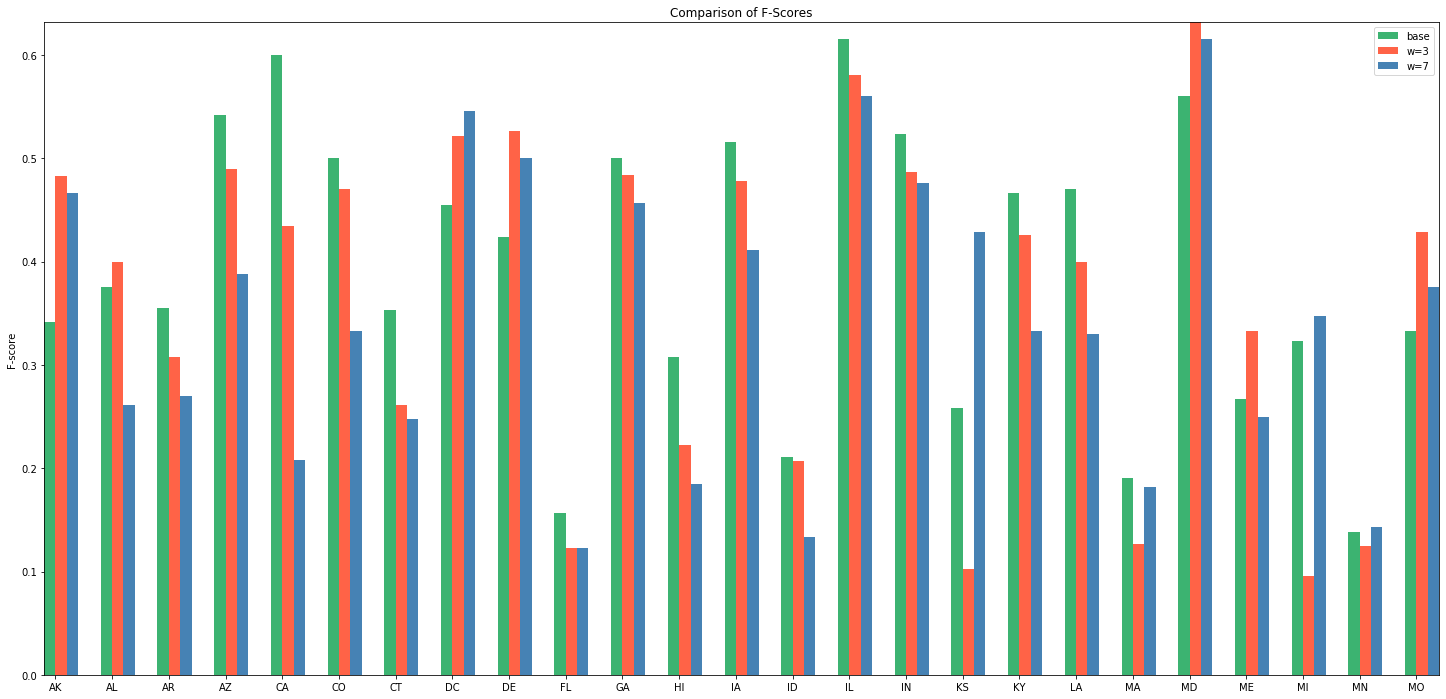

In [284]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(25)
X = [state[3:] for state in STATES[:25]]
ax.bar(_X - 0.1, state_fscore[:25], width=0.2, color='mediumseagreen', align='center', label="base")
ax.bar(_X + 0.1, state_fscore_S[:25], width=0.2, color='tomato', align='center', label="w=3")
ax.bar(_X + 0.3, state_fscore_S7[:25], width=0.2, color='steelblue', align='center', label="w=7")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.title("Comparison of F-Scores")
plt.ylabel("F-score")
plt.legend()
plt.show()

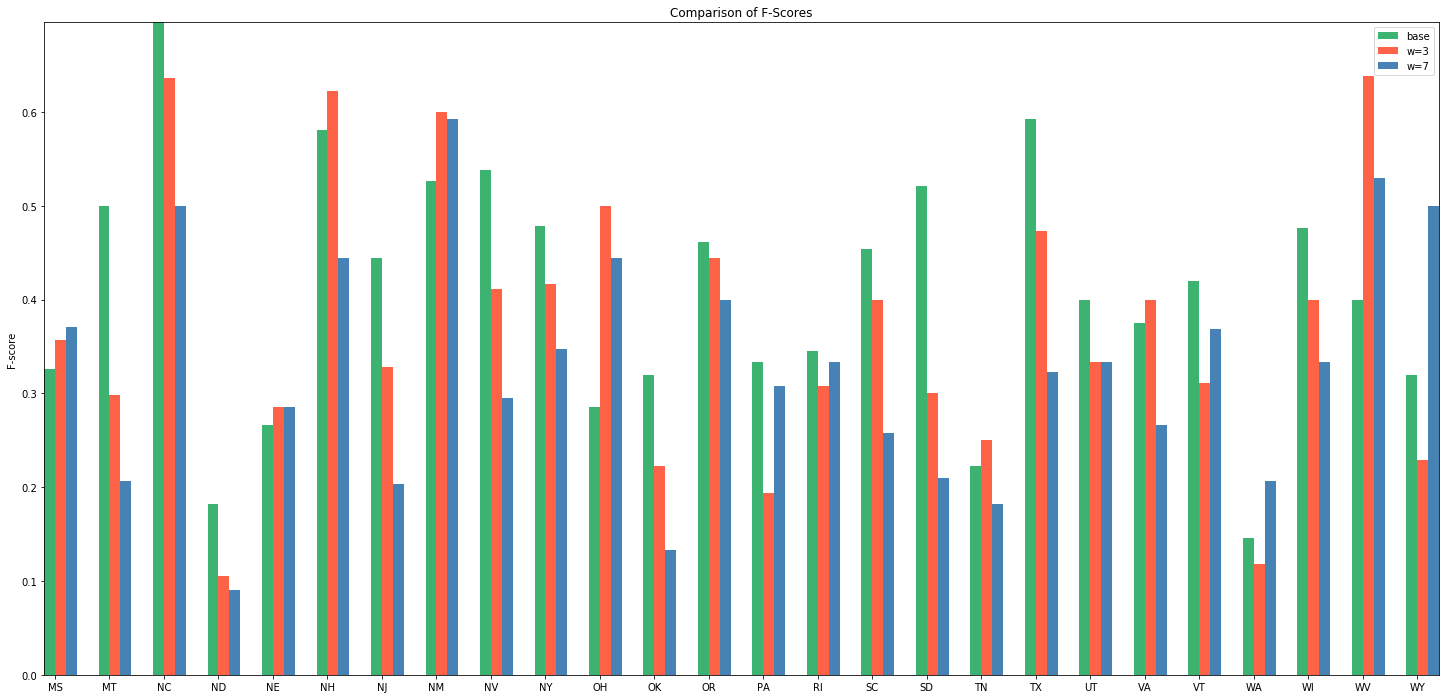

In [283]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(26)
X = [state[3:] for state in STATES[25:]]
ax.bar(_X - 0.1, state_fscore[25:], width=0.2, color='mediumseagreen', align='center', label="base")
ax.bar(_X + 0.1, state_fscore_S[25:], width=0.2, color='tomato', align='center', label="w=3")
ax.bar(_X + 0.3, state_fscore_S7[25:], width=0.2, color='steelblue', align='center', label="w=7")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.title("Comparison of F-Scores")
plt.ylabel("F-score")
plt.legend()
plt.show()

## Smoothing w = 21

In [61]:
Mar_smooth21 = load('results/smoothing_delta/w21/s21Mar20_01_31.npy')
Apr_smooth21 = load('results/smoothing_delta/w21/s21Apr20_01_30.npy')
May_smooth21 = load('results/smoothing_delta/w21/s21May20_01_31.npy')
Jun_smooth21 = load('results/smoothing_delta/w21/s21Jun20_01_30.npy')
Jul_smooth21 = load('results/smoothing_delta/w21/s21Jul20_01_31.npy')
Aug_smooth21 = load('results/smoothing_delta/w21/s21Aug20_01_31.npy')
Sept_smooth21 = load('results/smoothing_delta/w21/s21Sept20_01_30.npy')
Oct_smooth21 = load('results/smoothing_delta/w21/s21Oct20_01_31.npy')
Nov_smooth21 = load('results/smoothing_delta/w21/s21Nov20_01_30.npy')
Dec_smooth21 = load('results/smoothing_delta/w21/s21Dec20_01_31.npy')

new_delta_sMar21 = new_delta_mat(Mar_smooth21, period_31, 4, 7)[6:]
new_delta_sApr21 = new_delta_mat(Apr_smooth21, period_30, 4, 7)
new_delta_sMay21 = new_delta_mat(May_smooth21, period_31, 4, 7)
new_delta_sJun21 = new_delta_mat(Jun_smooth21, period_30, 4, 7)
new_delta_sJul21 = new_delta_mat(Jul_smooth21, period_31, 4, 7)
new_delta_sAug21 = new_delta_mat(Aug_smooth21, period_31, 4, 7)
new_delta_sSept21 = new_delta_mat(Sept_smooth21, period_30, 4, 7)
new_delta_sOct21 = new_delta_mat(Oct_smooth21, period_31, 4, 7)
new_delta_sNov21 = new_delta_mat(Nov_smooth21, period_30, 4, 7)
new_delta_sDec21 = new_delta_mat(Dec_smooth21, period_31, 4, 7)

# Joining of new delta: 7th Mar - Jan 2021
new_Sdelta21 = np.concatenate((new_delta_sMar21, new_delta_sApr21), axis=0)
new_Sdelta21 = np.concatenate((new_Sdelta21, new_delta_sMay21), axis=0)
new_Sdelta21 = np.concatenate((new_Sdelta21, new_delta_sJun21), axis=0)
new_Sdelta21 = np.concatenate((new_Sdelta21, new_delta_sJul21), axis=0)
new_Sdelta21 = np.concatenate((new_Sdelta21, new_delta_sAug21), axis=0)
new_Sdelta21 = np.concatenate((new_Sdelta21, new_delta_sSept21), axis=0)
new_Sdelta21 = np.concatenate((new_Sdelta21, new_delta_sOct21), axis=0)
new_Sdelta21 = np.concatenate((new_Sdelta21, new_delta_sNov21), axis=0)
new_Sdelta21 = np.concatenate((new_Sdelta21, new_delta_sDec21), axis=0)

In [92]:
# return TP_FP, FN, precision, recall, Fscore
TH = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
lag = np.arange(0,31)
state_best_th_lag21 = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all, target)
    
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   
            
            L_hat21 = pred_outbreak_detection(new_Sdelta21, L_hat_period_all, th)
            all_S21, L_window21 = comparison_all(state, L, L_hat21, l)
            metr = metrics(all_S21, L_window21)
            
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
                
    state_best_th_lag21[idx_s] = best_th_lag
np.save("best_th_lag_smooth21.npy", state_best_th_lag21)

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [93]:
state_best_th_lag_S21 = load('best_th_lag_smooth21.npy')
state_TP_FP_S21 = np.zeros((NUM_STATES,2))
state_FN_S21 = np.zeros(NUM_STATES)
state_fscore_S21 = np.zeros(NUM_STATES)
state_precision_S21 = np.zeros(NUM_STATES)
state_recall_S21 = np.zeros(NUM_STATES)

total_real_anomalies_S21 = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L_S = covid_case_outbreak_detection_all(actual_all, target)
            
    L_hat_S21 = pred_outbreak_detection(new_Sdelta21, L_hat_period_all, state_best_th_lag_S21[idx_s][0])
    all_S_smooth21, L_window_S21 = comparison_all(state, L_S, L_hat_S21, int(state_best_th_lag_S21[idx_s][1]))
    
    total_real_anomalies_S21[idx_s] = np.sum(L_window_S21)
    metr = metrics(all_S_smooth21, L_window_S21)
    state_TP_FP_S21[idx_s] = metr[0]
    state_FN_S21[idx_s] = metr[1]
    state_precision_S21[idx_s] = metr[2]
    state_recall_S21[idx_s] = metr[3]
    state_fscore_S21[idx_s] = metr[4]

In [139]:
L_HI = covid_case_outbreak_detection_all(actual_all, "HI")
L_HAT_HI = pred_outbreak_detection(new_Sdelta21, L_hat_period_all, 0)
fig = plt.figure(figsize=(25, 10))

smooth_z = z_score(new_Sdelta21, np.mean(new_Sdelta21, axis=0), np.std(new_Sdelta21, axis=0), 300)
normal_z = z_score(new_delta, np.mean(new_delta), np.std(new_delta), 300)

plt.plot(new_Sdelta21.transpose()[11], color='g',label="delta 21")
plt.plot(smooth_z.transpose()[11], color='red',label="z 21")
# plt.plot(L_HI, marker = 'x', markersize=5, linestyle="none",label="Case Anomalies")
# plt.plot(L_HAT_HI.transpose()[11][:10], marker = 'x', markersize=5, linestyle="none",label="SR Anomalies")
plt.legend()

plt.xlabel("day")
plt.ylabel("delta")

print(smooth_z.transpose()[11][:10])

In [71]:
from statsmodels.tsa.stattools import adfuller
print(" > Is the data stationary ?")
dftest = adfuller(new_Sdelta21.transpose()[], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value =  {:.8f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -3.655
P-value =  0.00480012
Critical values :
	1%: -3.4524859843440754 - The data is  stationary with 99% confidence
	5%: -2.871288184343229 - The data is  stationary with 95% confidence
	10%: -2.571964047565425 - The data is  stationary with 90% confidence


#### Saving

In [94]:
np.savetxt("state_TP_FP_S21.csv", state_TP_FP_S21, delimiter=",")
np.savetxt("state_FN_S21.csv", state_FN_S21, delimiter=",")
np.savetxt("state_precision_S21.csv", state_precision_S21, delimiter=",")
np.savetxt("state_recall_S21.csv", state_recall_S21, delimiter=",")
np.savetxt("state_fscore_S21.csv", state_fscore_S21, delimiter=",")
np.savetxt("total_real_anomalies_S21.csv", total_real_anomalies_S21, delimiter=",")
np.savetxt("state_best_th_lag_S21.csv", state_best_th_lag_S21, delimiter=",")

# Experiment 7.3: Flexible Matching

In [32]:
# Decreasing the FP
def comparison_flexi(target_region, L, L_hat, lag):
    target_reg_idx = get_target_region_idx(target_region)
    L_hat_region = L_hat.transpose()[target_reg_idx]
    period = L_hat.shape[0]
    L_window = window_L(L, lag, period)
    Lw = np.zeros(7)
    S = np.zeros((period, 2)) 
    documented = []
    for idx_L, L_hat_day in enumerate(L_hat_region): 

        if idx_L < 3: 
            w = np.arange(0, (idx_L+4))
        elif idx_L >= (period-3):
            w = np.arange((idx_L-3), period)
        else: 
            w = np.arange((idx_L-3), (idx_L+4))
        Lw = L_window[w]
        s = np.zeros(2)
        if L_hat_day == 1:
            if np.sum(Lw) > 0: 
                L_outbreaks = np.argwhere(Lw == 1).flatten()
                date_idx_L_outbreaks = w[L_outbreaks]

                undocumented = np.setdiff1d(date_idx_L_outbreaks, np.array(documented))
                if len(undocumented) > 0:
                    s[0] = 1
                    documented.append(undocumented[0])
            else:
                s[1] = 1
        S[idx_L] = s
    return S, L_window         

In [33]:
# return TP_FP, FN, precision, recall, Fscore
TH = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
lag = np.arange(0,31)
state_best_th_lag_flexi = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all, target)
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   
            
            L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, th)
            all_S, L_window = comparison_flexi(state, L, L_hat, l)
            metr = metrics(all_S, L_window)
            
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
                
    state_best_th_lag_flexi[idx_s] = best_th_lag
np.save("best_th_lag_flexi_base.npy", state_best_th_lag_flexi)

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Getting metrics

In [34]:
state_best_th_lag = load('best_th_lag_flexi_base.npy')
state_TP_FP = np.zeros((NUM_STATES,2))
state_FN = np.zeros(NUM_STATES)
state_fscore = np.zeros(NUM_STATES)
state_precision = np.zeros(NUM_STATES)
state_recall = np.zeros(NUM_STATES)

total_real_anomalies = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L = covid_case_outbreak_detection_all(actual_all, target)
            
    L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, state_best_th_lag[idx_s][0])
    
    all_S, L_window = comparison_flexi(state, L, L_hat, int(state_best_th_lag[idx_s][1]))
    total_real_anomalies[idx_s] = np.sum(L_window)
    metr = metrics(all_S, L_window)
    
    state_TP_FP[idx_s] = metr[0]
    state_FN[idx_s] = metr[1]
    state_precision[idx_s] = metr[2]
    state_recall[idx_s] = metr[3]
    state_fscore[idx_s] = metr[4]

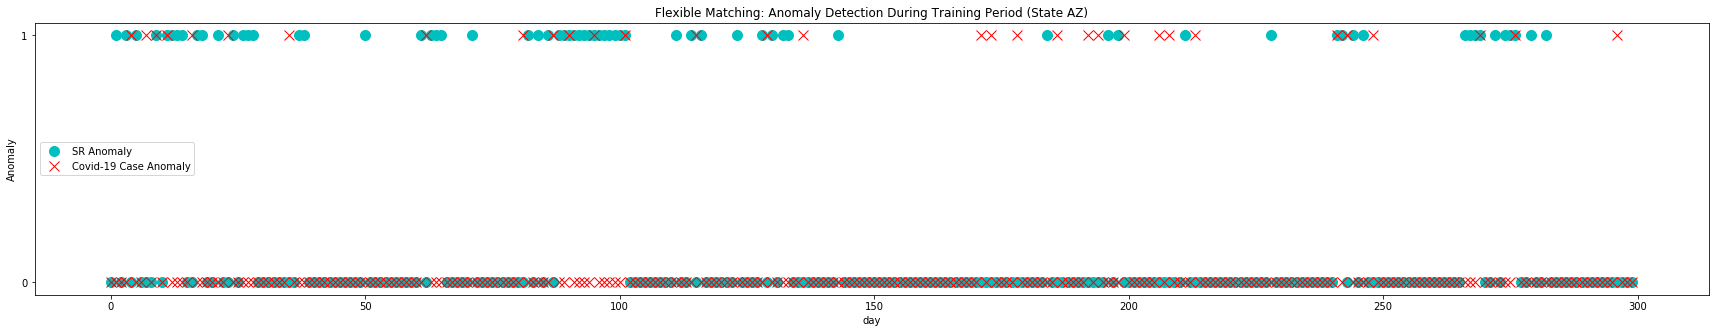

In [39]:
# precision, recall, Fscore
AZ = get_target_region_idx("US-AZ")
state_th = 0
state_lag = 0

L_AZ = covid_case_outbreak_detection_all(actual_all, "AZ")
L_hat_AZ = pred_outbreak_detection(new_delta, L_hat_period_all, state_th)
AZ_S, L_window_AZ = comparison_all("US-AZ", L_AZ, L_hat_AZ, state_lag)

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Flexible Matching: Anomaly Detection During Training Period (State AZ)")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(300)), L_hat_AZ.transpose()[AZ], marker='o',  markersize=10, color='c', linewidth=0, label="SR Anomaly")
ax.plot(np.array(range(300)), L_window_AZ, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
ax.legend(loc="center left")

#### Saving

In [ ]:
np.savetxt("state_TP_FP.csv", state_TP_FP, delimiter=",")
np.savetxt("state_FN.csv", state_FN, delimiter=",")
np.savetxt("state_precision.csv", state_precision, delimiter=",")
np.savetxt("state_recall.csv", state_recall, delimiter=",")
np.savetxt("state_fscore.csv", state_fscore, delimiter=",")
np.savetxt("total_real_anomalies.csv", total_real_anomalies, delimiter=",")
np.savetxt("state_best_th_lag.csv", state_best_th_lag, delimiter=",")

## EXPERIMENT 7.5: Excluding March and April

In [27]:
data_May = load('results/delta/May_01_31.npy')
data_Jun = load('results/delta/June_01_30.npy')
data_Jul = load('results/delta/Jul_01_31.npy')
data_Aug = load('results/delta/Aug_01_31.npy')
data_Sept = load('results/delta/Sept_01_30.npy')
data_Oct = load('results/delta/Oct_01_31.npy')
data_Nov = load('results/delta/Nov_01_30.npy')
data_Dec = load('results/delta/Dec_01_31.npy')
data_Jan21 = load('results/delta/Jan21_01_31.npy')
data_Feb21 = load('results/delta/Feb21_01_23.npy')

period_nov = data_Nov.shape[0]
period_31 = data_Jul.shape[0]
period_30 = data_Sept.shape[0]
period_feb = data_Feb21.shape[0]

# Where only considering Cough x Fever 
new_delta_Apr = new_delta_mat(data_Apr, period_30, 4, 7)
new_delta_May = new_delta_mat(data_May, period_31, 4, 7)
new_delta_Jun = new_delta_mat(data_Jun, period_30, 4, 7)
new_delta_Jul = new_delta_mat(data_Jul, period_31, 4, 7)
new_delta_Aug = new_delta_mat(data_Aug, period_31, 4, 7)
new_delta_Sept = new_delta_mat(data_Sept, period_30, 4, 7)
new_delta_Oct = new_delta_mat(data_Oct, period_31, 4, 7)
new_delta_Nov = new_delta_mat(data_Nov, period_30, 4, 7)
new_delta_Dec = new_delta_mat(data_Dec, period_31, 4, 7)
print("New delta created")

New delta created


In [45]:
# Joining of new delta: 7th Mar - Jan 2021
# new_delta_small = np.concatenate((new_delta_Apr, new_delta_May), axis=0)
new_delta_small = np.concatenate((new_delta_May, new_delta_Jun), axis=0)
new_delta_small = np.concatenate((new_delta_small, new_delta_Jul), axis=0)
new_delta_small = np.concatenate((new_delta_small, new_delta_Aug), axis=0)
new_delta_small = np.concatenate((new_delta_small, new_delta_Sept), axis=0)
new_delta_small = np.concatenate((new_delta_small, new_delta_Oct), axis=0)
new_delta_small = np.concatenate((new_delta_small, new_delta_Nov), axis=0)
new_delta_small = np.concatenate((new_delta_small, new_delta_Dec), axis=0)

# March 7th - 31 Dec 2020
L_hat_period_small = new_delta_small.shape[0]
print("Original training data loaded", L_hat_period_small)

Original training data loaded 245


In [46]:
# 30 days before 2021-02-23 is 2021-01-24
actual_all_small = actual_cases[(actual_cases.date >= '2020-05-01') & (actual_cases.date <= '2021-02-05')]
print("L")
print(min(actual_all_small.date) + " - " + max(actual_all_small.date))

L
2020-05-01 - 2021-02-05


__Base Model Edition__

In [47]:
# return TP_FP, FN, precision, recall, Fscore
TH = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
lag = np.arange(0,31)
small_best_th_lag = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all_small, target)
    
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   

            L_hat = pred_outbreak_detection(new_delta_small, L_hat_period_small, th)
            all_S, L_window = comparison_all(state, L, L_hat, l)
            metr = metrics(all_S, L_window)
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
                
    small_best_th_lag[idx_s] = best_th_lag
np.save("best_th_lag_small.npy", small_best_th_lag)

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [48]:
best_th_lag_small = load('best_th_lag_small.npy')
TP_FP_small = np.zeros((NUM_STATES,2))
FN_small = np.zeros(NUM_STATES)
fscore_small = np.zeros(NUM_STATES)
precision_small = np.zeros(NUM_STATES)
recall_small = np.zeros(NUM_STATES)

total_real_anomalies_small = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L_small = covid_case_outbreak_detection_all(actual_all_small, target)
            
    L_hat_small = pred_outbreak_detection(new_delta_small, L_hat_period_small, best_th_lag_small[idx_s][0])
    
    all_S_small, L_window_small = comparison_all(state, L_small, L_hat_small, int(best_th_lag_small[idx_s][1]))
    
    total_real_anomalies_small[idx_s] = np.sum(L_window_small)
    metr = metrics(all_S_small, L_window_small)
    TP_FP_small[idx_s] = metr[0]
    FN_small[idx_s] = metr[1]
    precision_small[idx_s] = metr[2]
    recall_small[idx_s] = metr[3]
    fscore_small[idx_s] = metr[4]

In [49]:
np.savetxt("TP_FP_small.csv", TP_FP_small, delimiter=",")
np.savetxt("FN_small.csv", FN_small, delimiter=",")
np.savetxt("precision_small.csv", precision_small, delimiter=",")
np.savetxt("recall_small.csv", recall_small, delimiter=",")
np.savetxt("fscore_small.csv", fscore_small, delimiter=",")
np.savetxt("total_real_anomalies_small.csv", total_real_anomalies_small, delimiter=",")
np.savetxt("best_th_lag_small.csv", best_th_lag_small, delimiter=",")

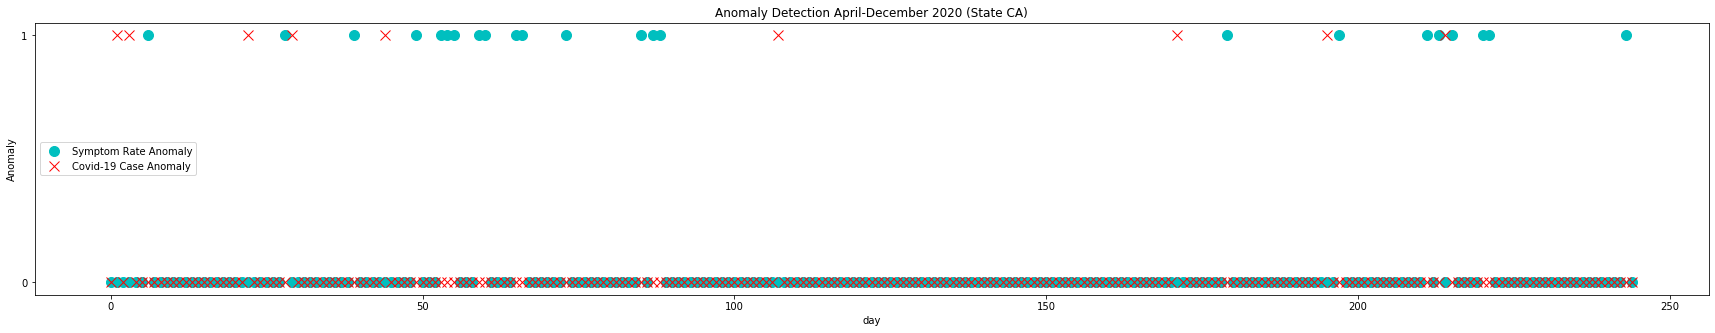

In [32]:
# precision, recall, Fscore
CA = get_target_region_idx("US-CA")
state_lag = best_th_lag_small[CA][1]
state_th = best_th_lag_small[CA][0]
L_CA = covid_case_outbreak_detection_all(actual_all, "CA")

L_hat_CA = pred_outbreak_detection(new_delta_small, L_hat_period_small, state_th)
CA_S, L_window_CA = comparison_all("US-CA", L_CA, L_hat_CA, int(state_lag))

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)

ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection April-December 2020 (State CA)")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(L_hat_period_small)),L_hat_CA.transpose()[CA], marker='o',  markersize=10, color='c', linewidth=0, label="Symptom Rate Anomaly")
ax.plot(np.array(range(L_hat_period_small)),L_window_CA, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
# ax.plot(np.array(range(L_hat_period_small)),new_delta_small.transpose()[CA][-L_hat_period_small:], marker='o',  markersize=10, color='r', linewidth=0, label="Delta")
ax.legend(loc="center left")

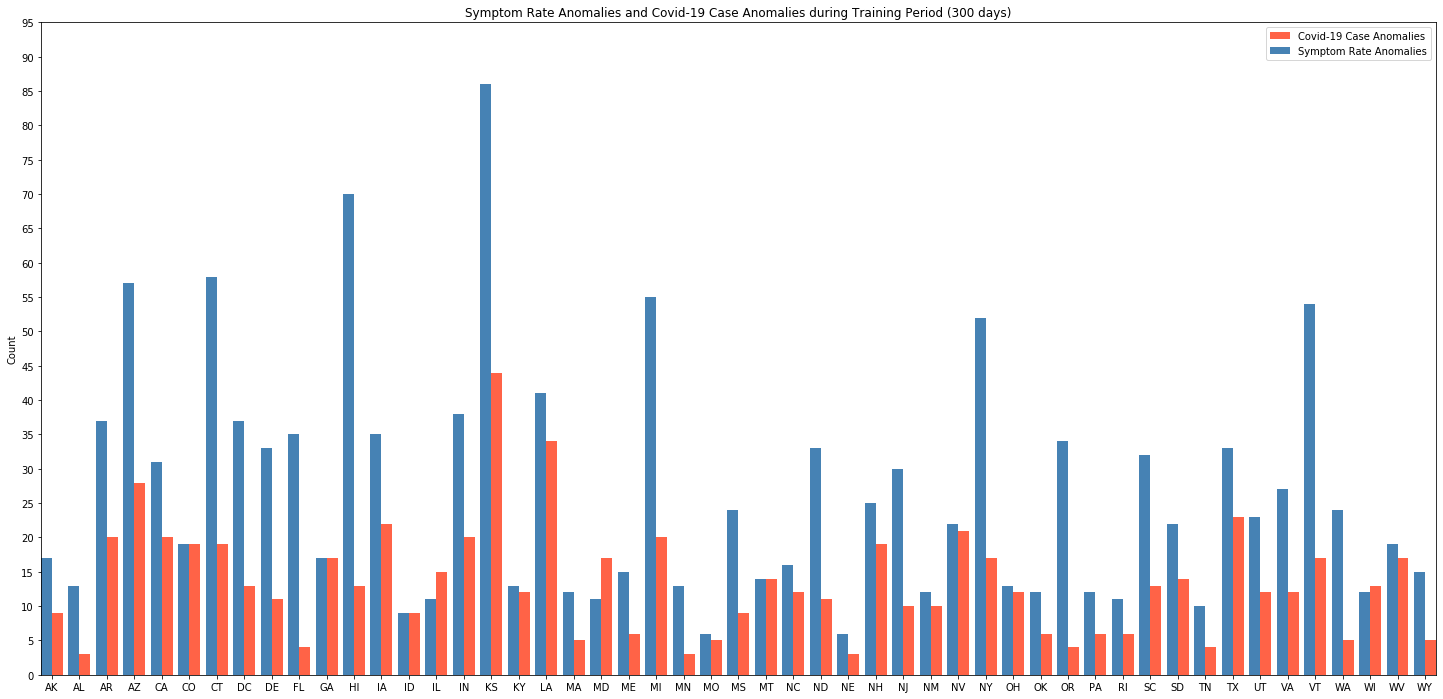

In [44]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(51)
X = [state[3:] for state in STATES]
ax.bar(_X + 0.2, [int(L_window) for L_window in total_real_anomalies_small], width=0.4, color='tomato', align='center', label="Covid-19 Case Anomalies")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in TP_FP_small], width=0.4, color='steelblue', align='center', label="Symptom Rate Anomalies")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 100, 5))
plt.title("Symptom Rate Anomalies and Covid-19 Case Anomalies during Training Period (300 days)")
plt.ylabel("Count")
plt.legend()
plt.show()

### Flexible

In [50]:
# return TP_FP, FN, precision, recall, Fscore
TH = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
lag = np.arange(0,31)
best_th_lag_small_flex = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all_small, target)
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   
            
            L_hat = pred_outbreak_detection(new_delta_small, L_hat_period_small, th)
            all_S, L_window = comparison_flexi(state, L, L_hat, l)
            metr = metrics(all_S, L_window)
            
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
                
    best_th_lag_small_flex[idx_s] = best_th_lag
np.save("best_th_lag_small_flex.npy", best_th_lag_small_flex)

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [51]:
best_th_lag_small = load('best_th_lag_small_flex.npy')
TP_FP_small = np.zeros((NUM_STATES,2))
FN_small = np.zeros(NUM_STATES)
fscore_small = np.zeros(NUM_STATES)
precision_small = np.zeros(NUM_STATES)
recall_small = np.zeros(NUM_STATES)

total_real_anomalies = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L = covid_case_outbreak_detection_all(actual_all_small, target)
            
    L_hat = pred_outbreak_detection(new_delta_small, L_hat_period_small, best_th_lag_small[idx_s][0])
    
    all_S, L_window = comparison_flexi(state, L, L_hat, int(best_th_lag_small[idx_s][1]))
    total_real_anomalies[idx_s] = np.sum(L_window)
    metr = metrics(all_S, L_window)
    
    TP_FP_small[idx_s] = metr[0]
    FN_small[idx_s] = metr[1]
    precision_small[idx_s] = metr[2]
    recall_small[idx_s] = metr[3]
    fscore_small[idx_s] = metr[4]

In [52]:
np.mean(fscore_small)

0.47938317129695995

# Visualising Covid-19 Testing Efforts

Text(0, 0.5, 'Count')

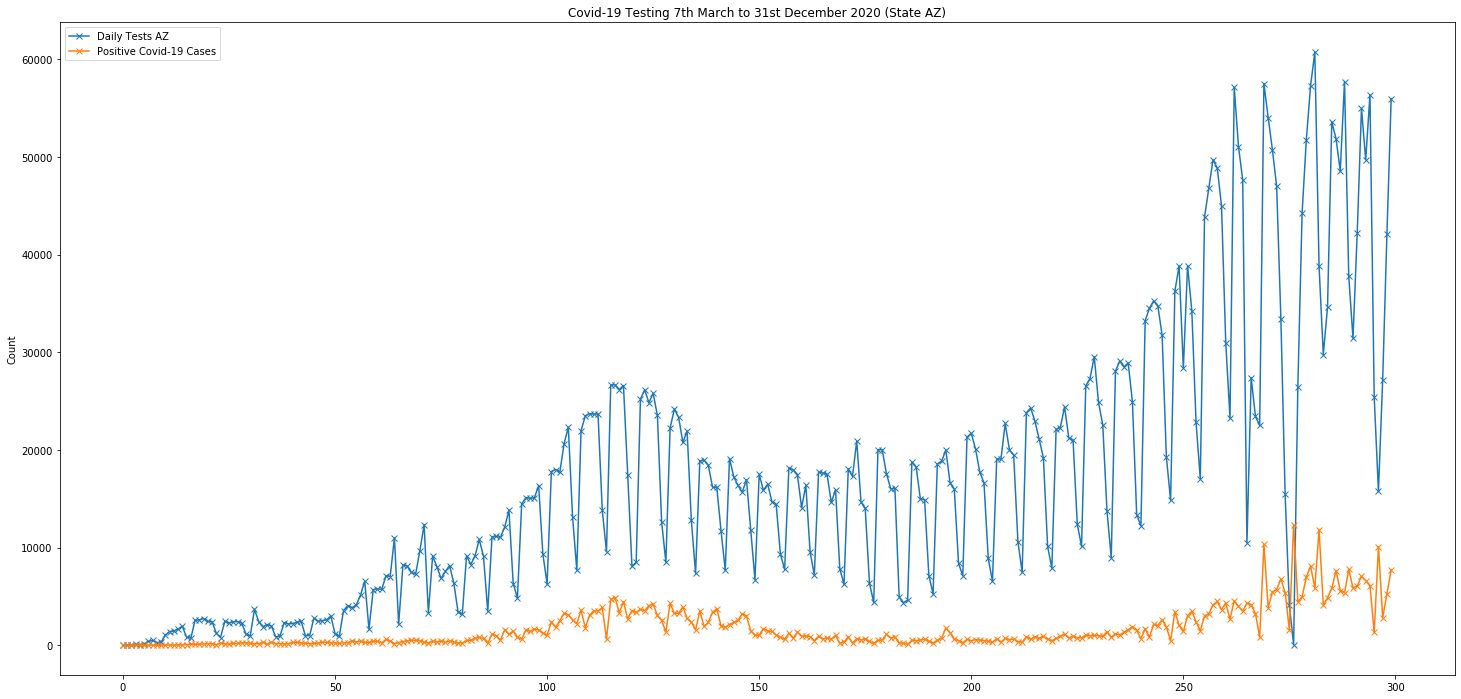

In [86]:
fig = plt.figure(figsize=(25, 12))
plt.plot(get_daily_tests("AZ", "2020-03-06", "2020-12-31")[1:].to_numpy(), marker="x", label="Daily Tests AZ")
plt.plot(actual_cases[actual_cases.state == "AZ"]['positiveIncrease'].to_numpy()[:300], marker="x", label="Positive Covid-19 Cases")
# plt.plot(get_daily_tests("CA", "2020-03-06", "2020-12-31")[1:].to_numpy(), marker="x", label="Daily Tests NC")
# plt.plot(get_daily_tests("CT", "2020-03-06", "2020-12-31")[1:].to_numpy(), marker="x", label="Daily Tests NC")
# plt.plot(get_daily_tests("AK", "2020-03-06", "2020-12-31")[1:].to_numpy(), marker="x", label="Daily Tests NC")
# plt.plot(get_daily_tests("WY", "2020-03-06", "2020-12-31")[1:].to_numpy(), marker="x", label="Daily Tests NC")
# plt.plot(get_daily_tests("DE", "2020-03-06", "2020-12-31")[1:].to_numpy(), marker="x", label="Daily Tests NC")
# plt.plot(np.arange(0,55,1),np.full(55, 1957))
plt.legend()
plt.title("Covid-19 Testing 7th March to 31st December 2020 (State AZ)")
plt.ylabel("Count")

In [87]:
np.mean(actual_cases[actual_cases.state == "AZ"]['positiveIncrease'])

2283.438202247191

# Testing (Based on Exp 1)

## Preparing Data: L HAT

Testing period: 1 Jan 2021 - 5 February 2021 (36 days)

In [52]:
new_delta_testing = np.concatenate((new_delta_Jan21, new_delta_Feb21[:5]), axis=0)
testing_period = len(new_delta_testing)
print(testing_period, "days")

test_ave_mat = average_delta(testing_period, new_delta_testing)
test_std_mat = std_dev_delta(testing_period, new_delta_testing)

36 days


In [53]:
actual_testing = actual_cases_testing[(actual_cases_testing.date >= "2021-01-01") & (actual_cases_testing.date <= "2021-03-31")]
print(actual_testing.date.nunique(), "days")
#REMEMBER TO EXCLUDE L[0]! (31st Dec 2020)
# 67 days initially

66 days


In [240]:
def z_score_test(delta_region_day, ave, std, period):
    z_score = np.zeros(period)
    for idx_d, delta in enumerate(delta_region_day):
        z_day = np.divide(np.subtract(delta, ave), std)
        z_score[idx_d] = z_day
    return z_score

def comparison_test(L, L_hat_region, lag):
    period = len(L_hat_region) 
    L_window = window_L(L, lag, period)
    Lw = np.zeros(7)
    S = np.zeros((period, 2))
    counted = []
    for idx_L, L_hat_day in enumerate(L_hat_region): 
        if idx_L < 3: 
            w = np.arange(0, (idx_L+4))
        elif idx_L >= (period-3):
            w = np.arange((idx_L-3), period)
        else: 
            w = np.arange((idx_L-3), (idx_L+4))
        Lw = L_window[w]
        s = np.zeros(2)
        if L_hat_day == 1:
            # Is there an outbreak in the Lw window? Get position of outbreak in window
            L_outbreaks = np.argwhere(Lw == 1).flatten()
            # Get outbreak date index
            date_idx_L_outbreaks = w[L_outbreaks]
            # Check to see if the indexes of outbreak dates has been counted. 
            new_outbreaks = np.setdiff1d(date_idx_L_outbreaks, np.array(counted))
            if new_outbreaks.shape[0] > 0:
                idx_outbreak = new_outbreaks[0]
                s[0] = 1
                counted.append(idx_outbreak)
            else:
                s[1] = 1
        S[idx_L] = s
    return S, L_window

def test(test_delta, actual_testing, testing_period, ave_mat, std_mat, best_th_lag):
    f_score = np.zeros(NUM_STATES)
    TP_FP = np.zeros((NUM_STATES,2))
    FN = np.zeros(NUM_STATES)
    true_anomalies = np.zeros(NUM_STATES)
    
    for idx_s, state in enumerate(STATES):
        target = state[3:]
        L_test = covid_case_outbreak_detection_all(actual_testing, target)
        
        # Testing period start 1st Jan
        L_test_p = L_test[300:]
        
        test_delta_region = test_delta.transpose()[idx_s]
        z_score_region = z_score_test(test_delta_region, ave_mat[idx_s], std_mat[idx_s], testing_period)
        L_hat_testing = L_score(z_score_region, best_th_lag[idx_s][0]) 
        
        S_test, L_window_test = comparison_test(L_test, L_hat_testing, int(best_th_lag[idx_s][1]))
        met = metrics(S_test, L_window_test)
        
        true_anomalies[idx_s] = np.sum(L_window_test)
        f_score[idx_s] = met[4]
        TP_FP[idx_s] = met[0]
        FN[idx_s] = met[1]
    return f_score, TP_FP, FN, true_anomalies

In [252]:
best_th_lag_small = load('best_th_lag_small.npy')
f_test, TP_FP_test, FN_test, L_window_sum = test(new_delta_testing, actual_testing, testing_period, test_ave_mat, test_std_mat, best_th_lag_small)

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


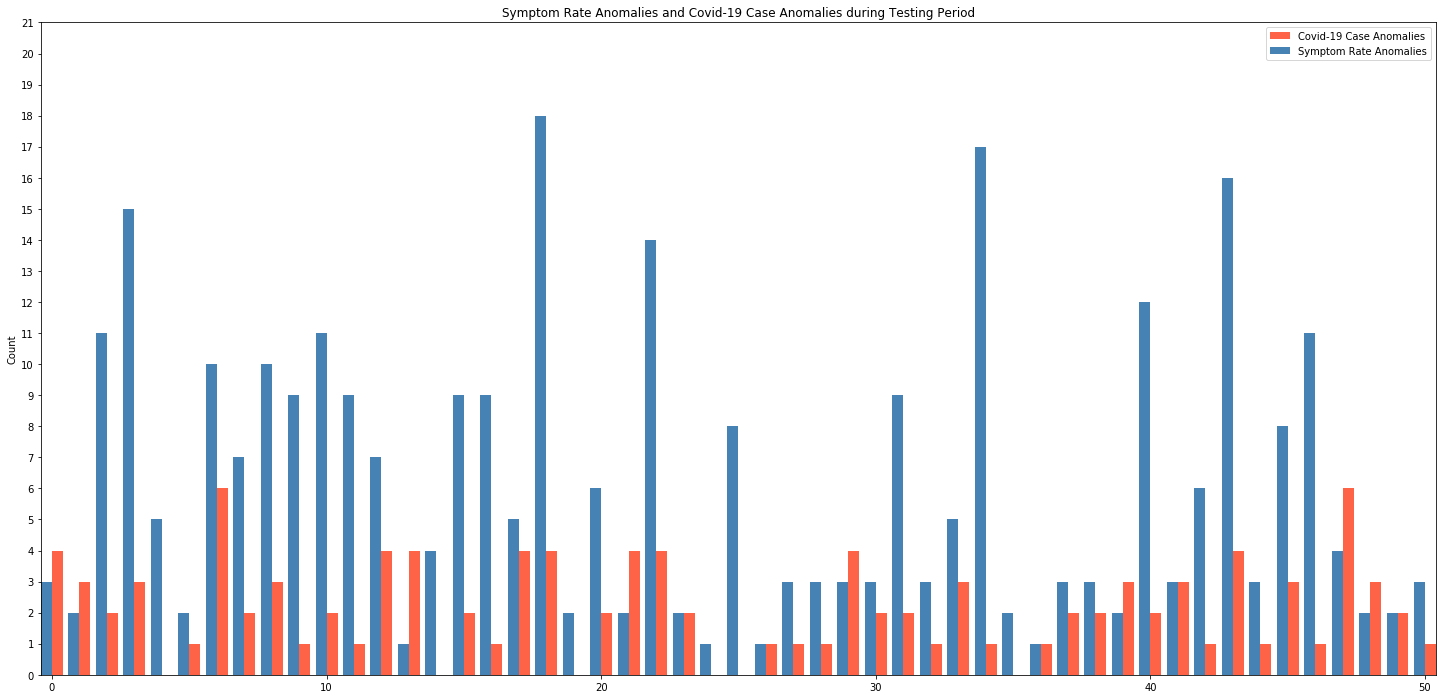

In [242]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(NUM_STATES)
X = [state[3:] for state in STATES]
ax.bar(_X + 0.2, [int(L_window) for L_window in L_window_sum], width=0.4, color='tomato', align='center', label="Covid-19 Case Anomalies")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in TP_FP_test], width=0.4, color='steelblue', align='center', label="Symptom Rate Anomalies")
ax.autoscale(tight=True)
plt.yticks(range(0, 22))
plt.title("Symptom Rate Anomalies and Covid-19 Case Anomalies during Testing Period")
plt.ylabel("Count")
plt.legend()
plt.show()

#### Saving values

In [254]:
np.savetxt("f_test.csv", f_test, delimiter=",")
np.savetxt("TP_FP_test.csv", TP_FP_test, delimiter=",")
np.savetxt("FN_test.csv", FN_test, delimiter=",")
np.savetxt("L_window_sum_test.csv", L_window_sum, delimiter=",")

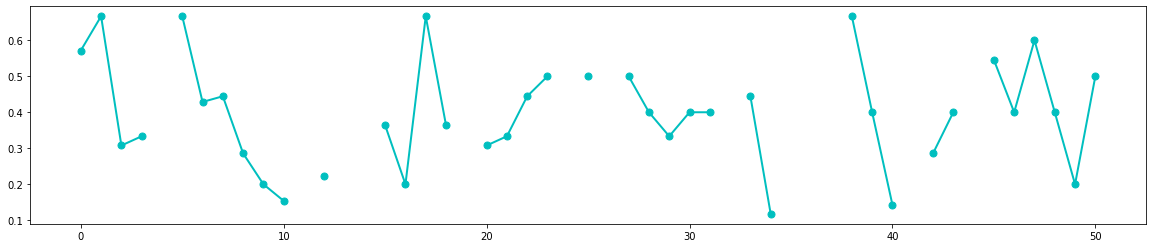

In [253]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(4)
fig.set_figwidth(20)
all = ax.plot(np.array(range(len(f_test))),f_test, marker='o',  markersize=7, color='c', linewidth=2)